# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *
from models import *
from fit_GLM_Network import *
pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:27316',
 'object_store_address': '/tmp/ray/session_2021-11-22_10-22-58_076065_475475/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-22_10-22-58_076065_475475/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2021-11-22_10-22-58_076065_475475',
 'metrics_export_port': 61496,
 'node_id': '39259f8dcc4a46c365b3eee3e681576e03152fd18c8bd3067d57d49d'}

In [2]:
args = arg_parser(jupyter=True)

MovModel = 1
LinMix = False
args['LinNonLinMix']=False
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# 012821/EE8P6LT
# 128: 070921/J553RT
# '110421/J569LT'# #'062921/G6HCK1ALTRN' '102621/J558NC'  # '110421/J569LT' #
# date_ani = '110421/J569LT'# args['date_ani']
# date_ani = '102621/J558NC' 
date_ani = '070921/J553RT' 
date_ani2 = '_'.join(date_ani.split('/'))
data_dir = Path(args['data_dir']).expanduser() / date_ani / stim_type 
save_dir = (Path(args['save_dir']).expanduser() / date_ani/ stim_type)
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_fm = save_dir.parent / 'fm1'
save_dir_hf = save_dir.parent / 'hf1_wn'
fig_dir = (Path(args['fig_dir']).expanduser()/'Encoding'/date_ani/stim_type)
fig_dir.mkdir(parents=True, exist_ok=True)
save_model = (save_dir/ 'models' / '{}'.format(MovModel))
save_model.mkdir(parents=True, exist_ok=True)

file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'mapping_json': Path('~/Research/Github/FreelyMovingEphys/probes/channel_maps.json').expanduser(),
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_' + stim_type,  # 070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }
params = {
    'Nepochs': args['Nepochs'],
    'model_dt': .05,
    'do_shuffle': False,
    'do_norm': False,
    'do_worldcam_correction': False,
    'lag_list': np.array([-2, -1, 0, 1, 2]),
    'free_move': free_move,
    'save_dir': save_dir,
    'data_dir': data_dir,
    'fig_dir': fig_dir,
    'save_model': save_model,
    'shiftn': 7, 
    'train_shifter': False,
    'MovModel': MovModel,
    'load_Vis' : True if MovModel==2 else False,
    'LinMix': False if args['LinNonLinMix']==True else args['LinMix'],
    'LinNonLinMix': args['LinNonLinMix'],
    'NKfold': args['NKfold'],
}
params['nt_glm_lag']=len(params['lag_list'])
Nepochs = params['Nepochs']
if params['do_worldcam_correction']:
    params['WC_type'] = 'C'
else:
    params['WC_type'] = 'UC'

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

avgfm_eye = np.load(save_dir_fm/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
if free_move:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1],data['train_roll'][:, np.newaxis], data['train_pitch'][:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1],data['test_roll'][:, np.newaxis], data['test_pitch'][:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1],data['model_roll'][:, np.newaxis], data['model_pitch'][:, np.newaxis]))
else:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['train_phi'].shape)[:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['test_phi'].shape)[:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['model_phi'].shape)[:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis]))

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
titles_all = []
for n in range(1, len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

##### Start GLM Parallel Processing #####
nks = np.shape(data['train_vid'])[1:]
nk = nks[0]*nks[1]*params['nt_glm_lag']
ncells = data['model_nsp'].shape[-1]
perms = np.array(list(itertools.combinations(np.arange(len(titles)), 4)))
# Reshape data (video) into (T*n)xN array
if params['train_shifter']:
    rolled_vid = np.hstack([np.roll(data['model_vid_sm'], nframes, axis=0) for nframes in params['lag_list']])  
    x_train = rolled_vid[train_idx] #.reshape(len(train_idx), -1)
    x_test = rolled_vid[test_idx] #.reshape(len(test_idx), -1)
    shift_in_tr = torch.from_numpy(move_train[:, (0, 1, 3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:, (0, 1, 3)].astype(np.float32)).to(device)
else:    
    model_vid_sm_shift = ioh5.load(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1))['model_vid_sm_shift{}'.format(params['shiftn'])]  # [:,5:-5,5:-5]
    nks = np.shape(model_vid_sm_shift)[1:]
    nk = nks[0]*nks[1]*params['nt_glm_lag']
    rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in params['lag_list']])  
    x_train = rolled_vid[train_idx].reshape(len(train_idx), -1)
    x_test = rolled_vid[test_idx].reshape(len(test_idx), -1)
    shift_in_tr = None
    shift_in_te = None


LinMix = params['LinMix']
LinNonLinMix = params['LinNonLinMix']
if MovModel == 0:
    model_type = 'Pytorch_Mot'
elif MovModel == 1:
    model_type = 'Pytorch_Vis'
elif MovModel == 2:
    if LinMix:
        model_type = 'Pytorch_Add'
    if LinNonLinMix:
        model_type = 'Pytorch_AddMul'
    else:
        model_type = 'Pytorch_Mul'
if args['NoL1']:
    model_type = model_type + '_NoL1'
ytr = torch.from_numpy(data['train_nsp'].astype(np.float32)).to(device)
yte = torch.from_numpy(data['test_nsp'].astype(np.float32)).to(device)

input_size = nk
output_size = ytr.shape[1]

# Reshape data (video) into (T*n)xN array
if MovModel == 0:
    mx_train = move_train[:, perms[ind]]
    mx_test = move_test[:, perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)
    xtrm = None
    xtem = None
    nk = xtr.shape[-1]
    params['move_features'] = None 
    sta_init = None
    params['lambdas'] = np.array([None])
    params['alphas'] = np.array([None])
    params['lambdas_m'] = np.array([None]) 
    params['alphas_m'] = np.array([None]) 
    nlam = len(params['lambdas'])
    nalph = len(params['alphas'])
    w_move_cv = np.zeros((nalph, nlam, output_size, nk))
    w_move_traces_all = np.zeros((nalph, nlam, params['Nepochs'], output_size, input_size))
elif MovModel == 1:
    xtr = torch.from_numpy(x_train).to(device)
    xte = torch.from_numpy(x_test).to(device)
    xtrm = None
    xtem = None
    params['move_features'] = None
    sta_init = torch.zeros((output_size, xtr.shape[-1]))
    params['alphas'] = np.array([.009 if args['NoL1']==False else None])
    params['lambdas'] = np.hstack((np.logspace(-3, 3.25, 10)[0], np.logspace(-3, 3.25, 20)))
    nlam = len(params['lambdas'])
    nalph = len(params['alphas'])
    params['lambdas_m'] = np.array(nlam*[None])
    params['alphas_m'] = np.array(nalph*[None])
    params['lr_w'] = [1e-5, 1e-3]
    params['lr_b'] = [1e-5, 1e-2]
elif MovModel == 2:
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    xtrm = torch.from_numpy(move_train[:, perms[ind]].astype(np.float32)).to(device)
    xtem = torch.from_numpy(move_test[:, perms[ind]].astype(np.float32)).to(device)
    params['move_features'] = xtrm.shape[-1]
    sta_init = torch.zeros((output_size, xtr.shape[-1]))
    params['alphas'] = np.array([None])
    params['lambdas'] =  np.hstack((np.logspace(-3, 3.25, 10)[0], np.logspace(-3, 3.25, 40)))
    nalph = len(params['alphas'])
    params['alphas_m'] = np.array(nalph*[None])
    params['lambdas_m'] = np.array([0]) # np.hstack((0, np.logspace(-5, 6, 40)))
    nlam = len(params['lambdas_m'])
    w_move_cv = np.zeros((nalph, nlam, output_size, params['move_features']))
    w_move_traces_all = np.zeros((nalph, nlam, Nepochs, output_size, params['move_features']))
    params['lr_w'] = [1e-5, 1e-3]
    params['lr_m'] = [1e-6, 1e-3]
    params['lr_b'] = [1e-6, 1e-1]

params['lr_shift'] = [1e-3,1e-1]
meanbias = torch.mean(torch.tensor(data['model_nsp'], dtype=torch.float32), axis=0)
params['Nepochs'] = params['Nepochs']
params['LinMix'] = LinMix
params['NonLinLayer'] = args['NonLinLayer']
params['Ncells'] = ytr.shape[-1]
print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


Done Loading Unaligned data
Model: 1, move_features: None


In [2]:
dataset_type = 'test'
def load_Kfold_forPlots(params, Kfold=0, dataset_type='test',thresh_fr = 1, tuning_thresh = .2):
    params['do_norm']=False
    data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
    train_idx = train_idx_list[Kfold]
    test_idx = test_idx_list[Kfold]
    data = load_Kfold_data(data,train_idx,test_idx,params)
    locals().update(data)
    locals().update(params)

    avgfm_eye = np.load(save_dir_fm/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
    if params['free_move']:
        move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1],data['train_roll'][:, np.newaxis], data['train_pitch'][:, np.newaxis]))
        move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1],data['test_roll'][:, np.newaxis], data['test_pitch'][:, np.newaxis]))
        model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1],data['model_roll'][:, np.newaxis], data['model_pitch'][:, np.newaxis]))
        model_move = (model_move - np.nanmean(model_move,axis=0))
        move_test = model_move[test_idx]
        move_train = model_move[train_idx]
    else:
        move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['train_phi'].shape)[:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis]))
        move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['test_phi'].shape)[:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis]))
        model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['model_phi'].shape)[:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis]))
    
    if dataset_type == 'train':
        nsp_raw = data['train_nsp']
        move_data = move_train.copy()
    else: 
        nsp_raw = data['test_nsp']
        move_data = move_test.copy()
        
    if params['free_move']:
        spk_percentile2 = np.arange(.125,1.125,.25)
        quartiles = np.arange(0,1.25,.25)
        tuning_curves = np.zeros((model_nsp.shape[1],len(titles),len(quartiles)-1))
        tuning_stds = np.zeros((model_nsp.shape[1],len(titles),1))
        tuning_curve_edges = np.zeros((model_nsp.shape[1],len(titles),len(quartiles)-1))
        ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
        for i,modeln in enumerate(range(len(titles))):
            for celln in np.arange(model_nsp.shape[1]):
                metric = move_data[:,modeln]
                nranges = np.quantile(metric,quartiles)
                stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
                stat_std, _, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='std',bins=nranges)
                tuning_curves[celln,modeln] = stat_range/params['model_dt']
                edge_mids = np.quantile(metric,spk_percentile2)
                tuning_curve_edges[celln,modeln] = edge_mids
                tuning_stds[celln,modeln] = stat_std.max()
            ax_ylims[:,modeln] = np.nanmax(tuning_curves[:,modeln],axis=-1)
        tc_mod = (np.max(tuning_curves,axis=-1,keepdims=True)-np.min(tuning_curves,axis=-1,keepdims=True))/(np.max(tuning_curves,axis=-1,keepdims=True)+np.min(tuning_curves,axis=-1,keepdims=True))
        avg_fr = np.mean(tuning_curves,axis=(-1,-2)).squeeze()

        tuning_sig = tc_mod.copy()
        tuning_sig[avg_fr<thresh_fr,:,0] = np.nan
        tuning_sig2 = np.any(tuning_sig>tuning_thresh,axis=1).squeeze()
        tuning_idx = np.where(tuning_sig2)[0]
    else: 
        tuning_curves=tuning_stds=tuning_curve_edges=ax_ylims=tc_mod=avg_fr=tuning_sig=tuning_sig2=tuning_idx = None
    return move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx
# move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=2, dataset_type='test')

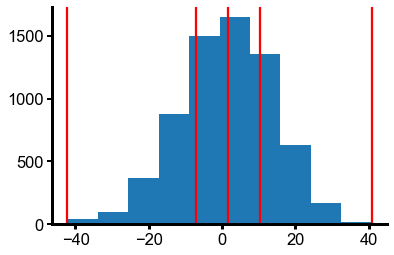

In [5]:
plt.hist(move_test[:,0])
quartiles = np.arange(0,1.25,.25)
nranges = np.quantile(move_test[:,0],quartiles)
stat_range, edges, _ = binned_statistic(move_test[:,0],data['test_nsp'][:,126],statistic='mean',bins=nranges)
for n in edges:
    plt.axvline(x=n,c='r')

# Loading Trained Networks

In [4]:
##### Loading Movement Trained Networks #####
a = 0; l = 0
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))

l1 = PoissonGLM_AddMult(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        meanfr=params['meanbias'],init_sta=params['sta_init'],
                        train_shifter=params['train_shifter'],
                        LinMix=False,NonLinLayer=params['NonLinLayer'], device=device,).to(device)


GLM_Network = GLM_VisMov_Mul
key_list = ['sta_all','bias', 'w_move','biasm']

param_dict = {}
for (pname, param),key in zip(l1.named_parameters(),key_list):
    if key == 'sta_all':
        param_dict[pname] = torch.from_numpy(GLM_Network[key].reshape(data['model_nsp'].shape[-1],-1).astype(np.float32))
    else: 
        param_dict[pname] = torch.from_numpy(GLM_Network[key].astype(np.float32))
l1.load_state_dict(param_dict)

<All keys matched successfully>

In [77]:
# GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000,Kfold))
GLM_VisMov_AddMul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_AddMul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 10000,Kfold))


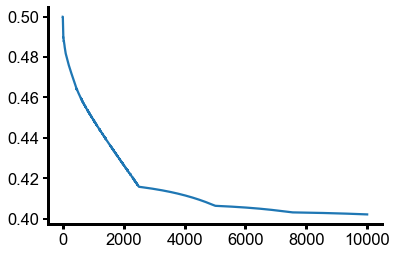

In [79]:
celln = 0
plt.plot(GLM_VisMov_AddMul['gamma_trace_all'][celln,:].T)
plt.show()

In [94]:
GLM_VisMov_AddMul.keys()

dict_keys(['bias', 'biasm_add', 'biasm_mul', 'gamma_trace_all', 'loss_regcv', 'pred_test', 'pred_train', 'r2_test', 'sta_all', 'test_nsp', 'tloss_trace_all', 'vloss_trace_all', 'w_move_add', 'w_move_mul'])

In [97]:
biasm_add[celln], biasm_mul[celln]

(-1.2779332, 1.9378697)

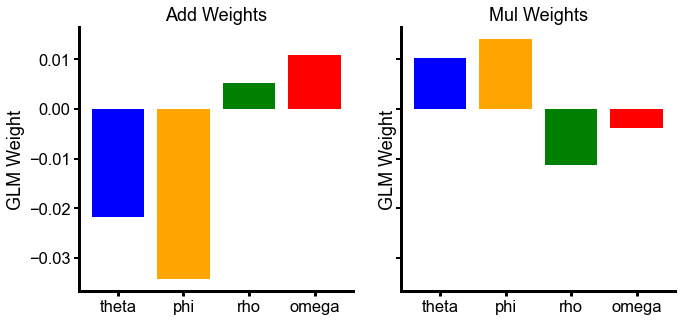

In [95]:
celln = 90
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
w_move_Add = GLM_VisMov_AddMul['w_move_add']
w_move_Mov = GLM_VisMov_AddMul['w_move_mul']
biasm_add = GLM_VisMov_AddMul['biasm_add']
biasm_mul = GLM_VisMov_AddMul['biasm_mul']
for modeln in range(len(titles)):
    axs[0].bar(modeln, w_move_Add[celln,modeln], color=clrs[modeln])
    axs[0].set_xticks(np.arange(0,len(titles)))
    axs[0].set_xticklabels(titles)
    axs[0].set_ylabel('GLM Weight')
    axs[0].set_title('Add Weights')
    axs[1].bar(modeln, w_move_Mov[celln,modeln], color=clrs[modeln])
    axs[1].set_xticks(np.arange(0,len(titles)))
    axs[1].set_xticklabels(titles)
    axs[1].set_ylabel('GLM Weight')
    axs[1].set_title('Mul Weights')
plt.tight_layout()

In [73]:
GLM_VisMov_Vis['sta_all'].shape

(128, 5, 30, 40)

In [11]:
sta = torch.from_numpy(GLM_VisMov_Vis['sta_all'])
sta_grid = vutils.make_grid(sta[:,2:3,:,:],nrow=10,normalize=True,scale_each=True)
plt.figure(figsize=(10,10))
plt.imshow(sta_grid[0], cmap='RdBu_r')

In [20]:
out = l1(xtr, xtrm,shift_in_tr)
loss = l1.loss(out, ytr)
pred = l1(xte, xtem,shift_in_te)
val_loss = l1.loss(pred, yte)
pred_test1 = pred.detach().cpu().numpy()

In [21]:
# sta = l1.weight.clone().detach().cpu().numpy()
# sta=sta.reshape((output_size,params['nt_glm_lag'])+nks)
sta = GLM_VisMov_Vis['sta_all']
sf = 4
sta_up = np.zeros((sta.shape[0], sta.shape[1],sf*sta.shape[-2], sf*sta.shape[-1]))
for n in range(sta_up.shape[0]):
    for t in range(sta_up.shape[1]):
        sta_up[n, t] = cv2.resize(sta[n, t], (sf*(sta.shape[-1]), sf*(sta.shape[-2])))

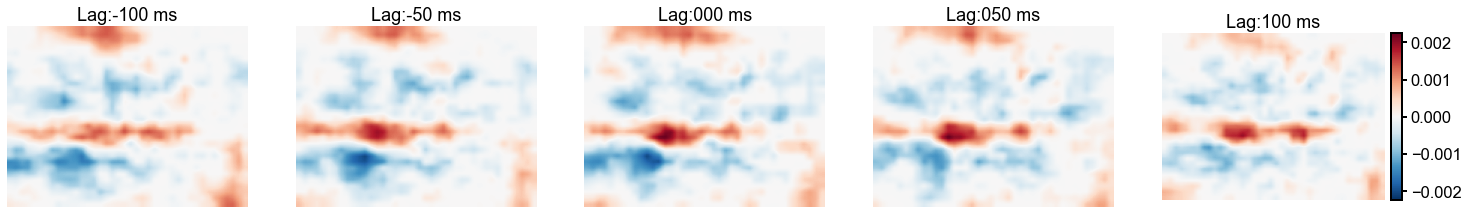

In [22]:
celln = 126
fig, top_grid = plt.subplots(1,params['nt_glm_lag'],figsize=(25,5))
crange = np.max(np.abs(sta_up[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_up[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

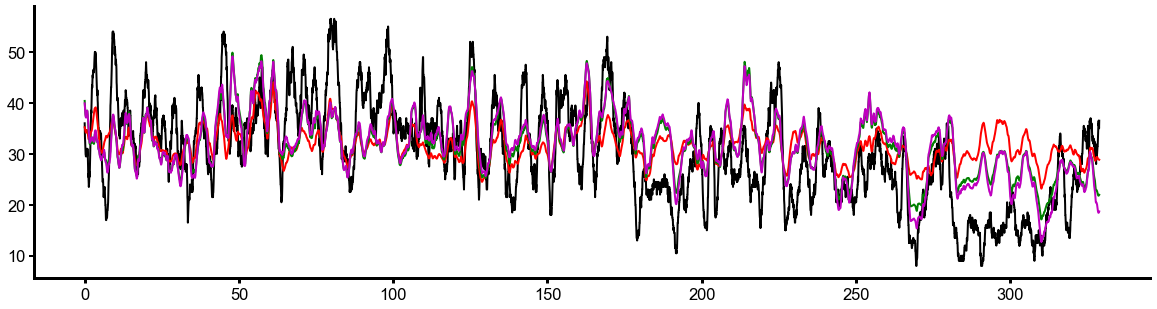

In [23]:
celln = 126
bin_length=40
fig,ax = plt.subplots(figsize=(20,5))
sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'r', lw=2)
ax.plot(np.arange(len(pred_smooth_Mul))*model_dt,pred_smooth_Mul,'g', lw=2)
ax.plot(np.arange(len(pred_smooth_Add))*model_dt,pred_smooth_Add,'m', lw=2)

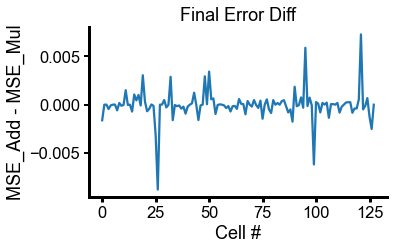

In [24]:

plt.plot(GLM_VisMov_Add['vloss_trace_all'][:,-1]-GLM_VisMov_Mul['vloss_trace_all'][:,-1])
plt.xlabel('Cell #')
plt.title('Final Error Diff')
plt.ylabel('MSE_Add - MSE_Mul')
plt.tight_layout()
# plt.savefig(fig_dir/'LLAdd_LLMul.png', facecolor='white', transparent=True)

In [63]:
GLM_VisMov_Vis['sta_all'].reshape(126)

(128, 5, 30, 40)

In [26]:
move_mult = move_test@GLM_VisMov_Mul['w_move'].T
move_add = move_test@GLM_VisMov_Add['w_move'].T

# vis = x_test@GLM_VisMov_Vis['sta_all'].reshape(x_test.shape[0]).T

In [27]:
GLM_VisMov_Mul['w_move'][126]


array([ 0.088861  ,  0.03695189, -0.0192946 ,  0.06515833])

Text(0.5, 1.0, 'celln:126')

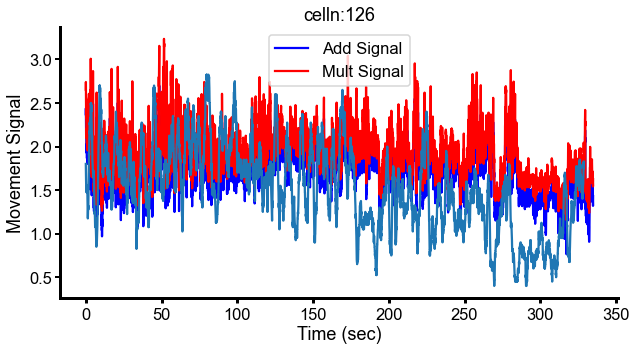

In [28]:

celln = 126
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(move_add))*model_dt,move_add[:,celln]+GLM_VisMov_Add['biasm'][celln], 'b', label='Add Signal')
plt.plot(np.arange(len(move_mult))*model_dt,np.exp(move_mult[:,celln]+GLM_VisMov_Mul['biasm'][celln]),'r', label='Mult Signal')
sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
plt.plot(np.arange(sp_smooth.shape[0])*model_dt,(sp_smooth*model_dt))
plt.xlabel('Time (sec)')
plt.ylabel('Movement Signal')
plt.legend()
plt.title('celln:{}'.format(celln))
# plt.savefig(fig_dir/'AddMul_MovSignal.png', facecolor='white', transparent=True)

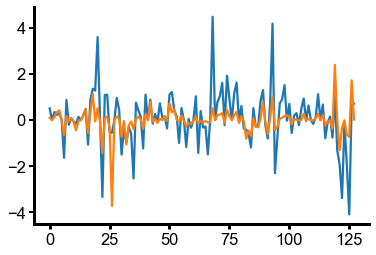

In [29]:
plt.plot(GLM_VisMov_Mul['biasm'])
plt.plot(GLM_VisMov_Add['biasm'])

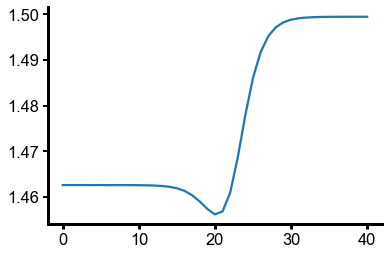

In [55]:
plt.plot(GLM_VisMov_Mul['loss_regcv'][0,:,126])


In [28]:
np.corrcoef(GLM_VisMov_Vis['test_nsp'][:,celln],GLM_VisMov_Add['pred_test'][:,celln])[0,1]**2

0.0801772221949897

In [29]:
np.corrcoef(GLM_VisMov_Vis['test_nsp'][:,celln],GLM_VisMov_Mul['pred_test'][:,celln])[0,1]**2

0.07133093735275818

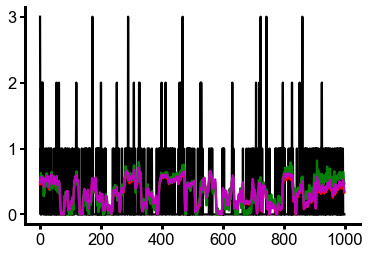

In [24]:
plt.plot(GLM_VisMov_Vis['test_nsp'][5000:6000,celln],'k')
plt.plot(GLM_VisMov_Vis['pred_test'][5000:6000,celln],'r')
plt.plot(GLM_VisMov_Add['pred_test'][5000:6000,celln],'g')
plt.plot(GLM_VisMov_Mul['pred_test'][5000:6000,celln],'m')

# Single Training

In [72]:
lr = 1e-3
for n in range(2000):
    lr = lr*.995

In [9]:
# params['alphas_m'] = np.array([2])
a = 0
Nepochs=5000
params['lr_m'] = [1e-6, 1e-2]
params['lr_b'] = [1e-6, 1e-1]
params['LinMix'] = False
# params['lambdas_m'] = np.hstack((np.logspace(-3, 5, 10)[0], np.logspace(-3, 5, 20)))
params['NonLinLayer'] = False
nlam=1
loss_regcv = np.zeros((nalph, nlam, output_size))
pred_cv = np.zeros((x_test.shape[0], nalph, nlam, output_size), dtype=np.float32)
out_cv = np.zeros((x_train.shape[0], nalph, nlam, output_size), dtype=np.float32)
w_cv = np.zeros((x_train.shape[-1], nalph, nlam, output_size), dtype=np.float32)
bias_cv = np.zeros((nalph, nlam, output_size), dtype=np.float32)
biasm_cv = np.zeros((nalph, nlam, output_size), dtype=np.float32)
tloss_trace_all = np.zeros((nalph, nlam, Nepochs, output_size), dtype=np.float32)
vloss_trace_all = np.zeros((nalph, nlam, Nepochs, output_size), dtype=np.float32)
bias_traces_all = np.zeros((nalph, nlam, Nepochs, output_size), dtype=np.float32)
biasm_traces = np.zeros((Nepochs, output_size), dtype=np.float32)
w_move_traces = np.zeros((Nepochs, output_size, params['move_features']))
# pbar = tqdm(params['lambdas_m'])
pbar = tqdm(params['lambdas_m'])
for l, reg_lam in enumerate(pbar):
    l1,optimizer,scheduler = get_model(input_size, output_size, MovModel, device, l, a, params)
    vloss_trace = np.zeros((Nepochs, ytr.shape[-1]), dtype=np.float32)
    tloss_trace = np.zeros((Nepochs, ytr.shape[-1]), dtype=np.float32)
    if pbar is None:
        pbar = pbar2 = tqdm(np.arange(Nepochs))
    else:
        pbar2 = np.arange(Nepochs)
    for batchn in pbar2:
        out = l1(xtr, xtrm, shift_in_tr)
        loss = l1.loss(out, ytr)
        pred = l1(xte, xtem, shift_in_te)
        val_loss = l1.loss(pred, yte)
        vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
        tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
        pbar.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
        pbar.refresh()
        optimizer.zero_grad()
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        if w_move_traces is not None:
            w_move_traces[batchn] = l1.move_weights.clone().detach().cpu().numpy()
        if biasm_traces is not None:
            biasm_traces[batchn] = l1.bias_m.clone().detach().cpu().numpy()
    tloss_trace_all[a, l] = tloss_trace
    vloss_trace_all[a, l] = vloss_trace
    bias_cv[a, l] = l1.bias.clone().cpu().detach().numpy()
    if MovModel != 0:
        w_cv[:, a, l] = l1.weight.clone().cpu().detach().numpy().T  
    if MovModel == 0:
        w_move_cv[a, l] = l1.weight.clone().cpu().detach().numpy()  
    elif MovModel != 1:
        if params['NonLinLayer']:
            pass
            # w_move_cv[a,l] = l1.NonLinMixLayer[0].weight.clone().cpu().detach().numpy()
            # biasm_cv[a,l] = l1.NonLinMixLayer[0].bias.clone().cpu().detach().numpy()
        else:
            biasm_cv[a,l] = l1.bias_m.clone().cpu().detach().numpy()
            w_move_cv[a, l] = l1.move_weights.clone().cpu().detach().numpy()  
        
    pred = l1(xte, xtem)
    loss_regcv[a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    
    pred_cv[:, a, l] = pred.detach().cpu().numpy().squeeze()
    out = l1(xtr, xtrm)
    out_cv[:, a, l] = out.detach().cpu().numpy().squeeze()


if MovModel != 0:
    w_cv2 = w_cv.T.reshape((output_size, nlam, nalph, params['nt_glm_lag'],)+nks)
if (MovModel ==1):
    loss_regcv[:, 0, :] = np.nan
malph, mlam, cellnum = np.where(loss_regcv == np.nanmin(loss_regcv, axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]
sta_all = w_cv[:, malph, mlam, cellnum].T.reshape((len(cellnum), params['nt_glm_lag'],)+nks)
pred_test = pred_cv[:, malph, mlam, cellnum]
pred_train = out_cv[:, malph, mlam, cellnum]
bias = bias_cv[malph, mlam, cellnum]
tloss_trace_all2 = tloss_trace_all[malph, mlam, :, cellnum]
vloss_trace_all2 = vloss_trace_all[malph, mlam, :, cellnum]
bias_traces = bias_traces_all[malph, mlam, :, cellnum]

output_size = len(cellnum)
if MovModel != 1:
    w_move = w_move_cv[malph, mlam, cellnum]
    # w_move_traces = w_move_traces_all[malph, mlam, :, cellnum]
    # biasm = biasm_cv[malph,mlam,cellnum]
bin_length = 40
r2_test = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(data['test_nsp'][:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_test[:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    r2_test[celln] = (np.corrcoef(sp_smooth, pred_smooth)[0, 1])**2


Loss: 0.462: 100%|██████████| 1/1 [00:30<00:00, 30.83s/it]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [13]:
out = l1(xtr, xtrm, shift_in_tr)
loss = l1.loss(out, ytr)
loss.backward(mask)
l1.move_weights.grad[126]

tensor([-2.3029e-02,  1.0477e-02,  2.8819e-05,  1.7024e-04], device='cuda:0')

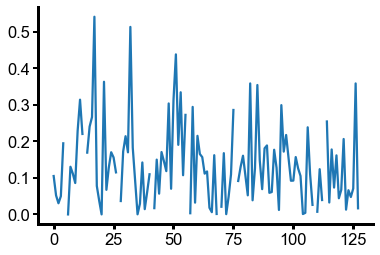

In [15]:
plt.plot(r2_test)


In [ ]:
celln = 126
plt.plot(w_move_traces[:,celln])
np.sum(np.isnan(r2_test))


0.20658324803587233


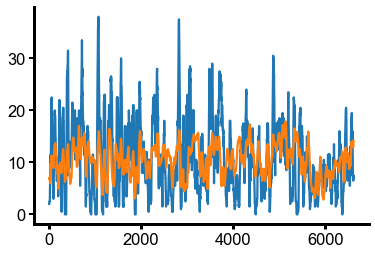

In [19]:
celln = 126
sp_smooth = ((np.convolve(data['test_nsp'][:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
pred_smooth = ((np.convolve(pred_test[:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
r2 = (np.corrcoef(sp_smooth, pred_smooth)[0, 1])**2
plt.plot(sp_smooth)
plt.plot(pred_smooth)
print(r2)


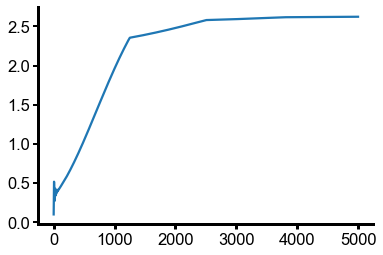

In [24]:
plt.plot(biasm_traces[:,celln])

In [11]:
# plt.plot(move_test@w_move[celln].T + biasm[celln])
plt.plot(np.exp(move_test@w_move[celln].T + biasm[celln]))


NameError: name 'biasm' is not defined

In [12]:

if MovModel == 0:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_test,
                'bias': bias,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'pred_train': pred_train,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_test': r2_test,
                'sta_all': sta_all,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_test,
                'bias': bias,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'pred_train': pred_train,
                }
else:
    GLM_Data = {'r2_test': r2_test,
                'sta_all': sta_all,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_test,
                'bias': bias,
                'biasm': biasm,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'pred_train': pred_train,
                'w_move': w_move}
if params['do_shuffle']:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_shuffled.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, Nepochs)
else:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, Nepochs)
ioh5.save(save_datafile, GLM_Data)

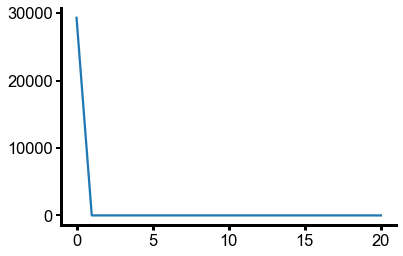

In [6]:
plt.plot(loss_regcv[0,:,126])

In [7]:
xtrm.shape,l1.biasm_all.shape

(torch.Size([15628, 4]), torch.Size([128, 4]))

In [6]:
(xtrm+l1.biasm_all).shape

RuntimeError: The size of tensor a (15628) must match the size of tensor b (128) at non-singleton dimension 0

In [5]:
torch.prod(xtrm,dim=1,keepdim=True).shape

torch.Size([15628, 1])

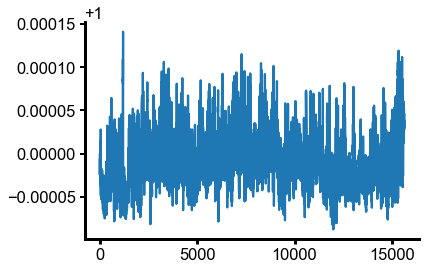

In [9]:
plt.plot(torch.exp(xtrm.matmul(l1.move_weights.T) + l1.bias_m)[:,126].clone().cpu().detach())

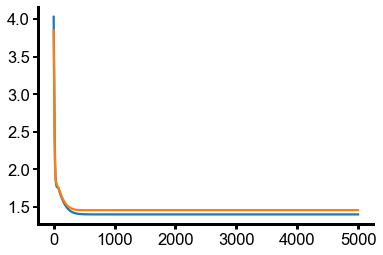

In [11]:
celln = 126
plt.figure()
plt.plot(tloss_trace_all2[celln,:])
plt.plot(vloss_trace_all2[celln,:])

# w_move1 = l1.move_weights.clone().detach().cpu().numpy()
# plt.figure()
# plt.bar(np.arange(4),w_move1[celln])

# plt.figure()
# bias_m = l1.bias_m.clone().detach().cpu().numpy()
# plt.plot(bias_m)

(0.3406544995464552, 0.16076492400306275)

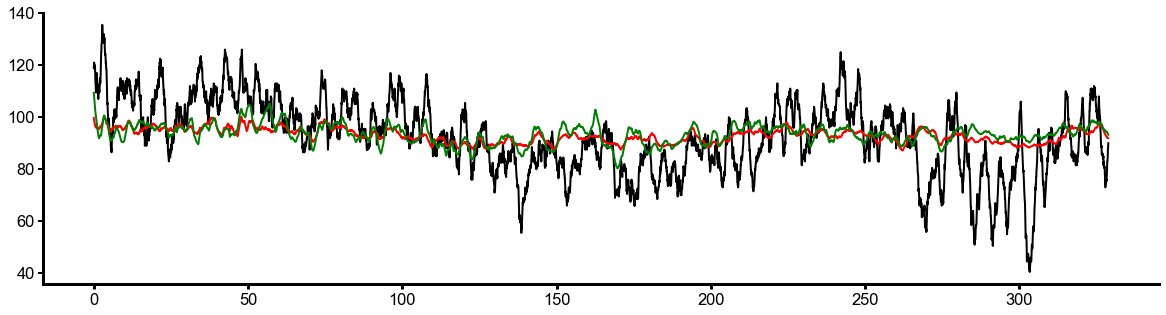

In [11]:
celln = 99
bin_length=40
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))

fig,ax = plt.subplots(figsize=(20,5))
sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
pred_smooth = ((np.convolve(pred_test[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)

pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_Mul))*model_dt,pred_smooth_Mul,'g', lw=2)

r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2
r2 = np.corrcoef(sp_smooth,pred_smooth)[0,1]**2
r2,r2_Mul

In [ ]:
celln = 25
fig, ax = plt.subplots(figsize=(20,10))
for modeln in range(len(titles)):
    ax.bar(modeln, w_move[celln,modeln])
    ax.set_xticks(np.arange(0,len(titles)))
    ax.set_xticklabels(titles,rotation = 45)
    ax.set_ylabel('GLM Weight')
    ax.set_title('Add Weights')

# Plotting

## Scatter Plot

In [4]:
Nepochs = 5000
r2_Mot = np.zeros((params['NKfold'],output_size))
r2_Vis = np.zeros((params['NKfold'],output_size))
r2_Add = np.zeros((params['NKfold'],output_size))
r2_Mul = np.zeros((params['NKfold'],output_size))
r2_AddMul = np.zeros((params['NKfold'],output_size))
for Kfold in range(params['NKfold']):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs,Kfold))
    GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
    GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
    GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
    GLM_VisMov_AddMul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_AddMul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 10000,Kfold))
    r2_Mot[Kfold] = GLM_VisMov_Mot['r2_test'].copy()
    r2_Vis[Kfold] = GLM_VisMov_Vis['r2_test'].copy()
    r2_Add[Kfold] = GLM_VisMov_Add['r2_test'].copy()
    r2_Mul[Kfold] = GLM_VisMov_Mul['r2_test'].copy()
    r2_AddMul[Kfold] = GLM_VisMov_AddMul['r2_test'].copy()

Done Loading Unaligned data
Done Loading Unaligned data
Done Loading Unaligned data


/tmp/ipykernel_286731/2280448249.py:7: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Vis,axis=0)[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
/tmp/ipykernel_286731/2280448249.py:8: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0)[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
/tmp/ipykernel_286731/2280448249.py:9: RuntimeWarning: Mean of empty slice
  yvals2 = np.nanmean(r2_Add,axis=0)[tuning_sig2]


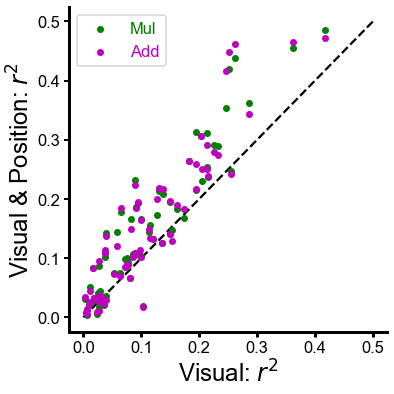

In [65]:
a = 0; l = 0
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40
fig, ax = plt.subplots(figsize=(6,6))
xvals = np.nanmean(r2_Vis,axis=0)[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals2 = np.nanmean(r2_Add,axis=0)[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, .51)
ax.scatter(xvals,yvals,30,c='g', label='Mul')
ax.scatter(xvals,yvals2,30,c='m', label='Add')
# ax.scatter(xvals,yvals3,30,c='k', label='AddMul')
ax.plot(np.linspace(lims[0],.5),np.linspace(lims[0],.5),'k--',zorder=0)
ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('Visual & Position: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,.6,.1))
ax.set_yticklabels(np.round(np.arange(0,.6,.1),decimals=1))
leg = ax.legend()
for handle, text in zip(leg.legendHandles, leg.get_texts()):
    text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()
# fig.savefig(fig_dir/'VisMov_Mul_binlen{}_Kfold{:02d}.pdf'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
xvals = np.nanmean(r2_Add,axis=0)[r2_sig2] - np.nanmean(r2_Vis,axis=0)[r2_sig2]# GLM_VisMov_Add['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[r2_sig2] - np.nanmean(r2_Vis,axis=0)[r2_sig2]# GLM_VisMov_Mul['r2_test'][tuning_sig2]-GLM_VisMov_Vis['r2_test'][tuning_sig2]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (lim_min, lim_max)
ax.scatter(xvals,yvals,30,c='k')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('(Visual + Position) - Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('(Visual * Position) - Visual: $r^2$',fontsize=fontsize)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()

# fig.savefig(fig_dir/'AddMVis_Vs_MulMVis_NoL1_binlen{}_Kfold{:02d}.pdf'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')

In [5]:
thresh_fr = 1
r2_thresh=.05
r2_sigP = np.nanmean(r2_Mot,axis=0)
r2_sigV = np.nanmean(r2_Vis,axis=0)
r2_sig2 = (r2_sigP>r2_thresh) & (r2_sigV>r2_thresh) & (avg_fr>thresh_fr)
r2_idx = np.where(r2_sig2)[0]
np.sum(r2_sig2)

/tmp/ipykernel_320313/4257152574.py:4: RuntimeWarning: Mean of empty slice
  r2_sigV = np.nanmean(r2_Vis,axis=0)


38

/tmp/ipykernel_218518/2816303954.py:6: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Add,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
/tmp/ipykernel_218518/2816303954.py:7: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]


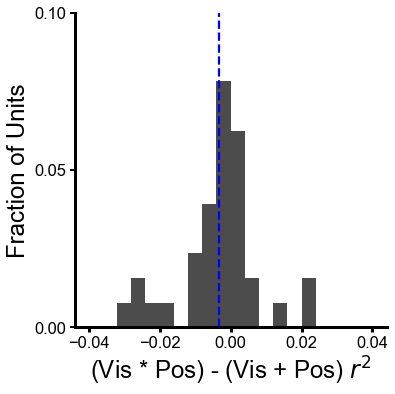

In [70]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
bin_length=40
fig, ax = plt.subplots(1,figsize=(6,6))
xvals = np.nanmean(r2_Add,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]

dwidth = .004
count,edges = np.histogram(yvals-xvals, bins=np.arange(-.04,.04+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='k',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(yvals-xvals),c='b',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('(Vis * Pos) - (Vis + Pos) $r^2$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
ax.set_yticks(np.arange(0,.2,.05))
ax.set_ylim(0,.1)
plt.tight_layout()
fig.savefig(fig_dir/'Add_M_Mul_Hist_binlen{}_Kfold{:02d}.pdf'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight', dpi=300)

/tmp/ipykernel_286731/373611314.py:6: RuntimeWarning: Mean of empty slice
  xvals = np.nanmean(r2_Add,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
/tmp/ipykernel_286731/373611314.py:7: RuntimeWarning: Mean of empty slice
  yvals = np.nanmean(r2_Mul,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
/tmp/ipykernel_286731/373611314.py:8: RuntimeWarning: Mean of empty slice
  yvals2 = np.nanmean(r2_AddMul,axis=0)[r2_sig2]


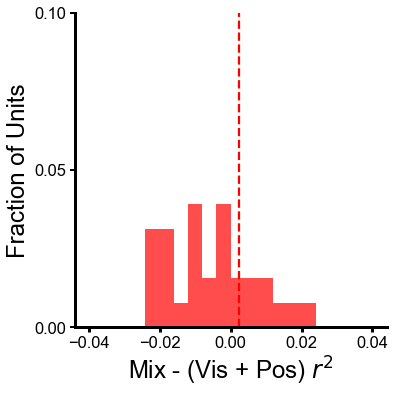

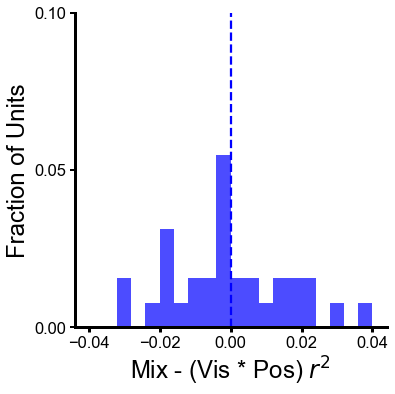

In [71]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
bin_length=40
fig, ax = plt.subplots(1,figsize=(6,6))
xvals = np.nanmean(r2_Add,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
yvals = np.nanmean(r2_Mul,axis=0)[r2_sig2] #- np.nanmean(r2_Vis,axis=0)[tuning_sig2]
yvals2 = np.nanmean(r2_AddMul,axis=0)[r2_sig2]

dwidth = .004
count,edges = np.histogram(yvals2-xvals, bins=np.arange(-.04,.04+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='r',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(yvals2-xvals),c='r',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('Mix - (Vis + Pos) $r^2$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
ax.set_yticks(np.arange(0,.2,.05))
ax.set_ylim(0,.1)
plt.tight_layout()

dwidth = .004
fig, ax = plt.subplots(1,figsize=(6,6))
count,edges = np.histogram(yvals2-yvals, bins=np.arange(-.04,.04+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='b',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(yvals-yvals),c='b',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('Mix - (Vis * Pos) $r^2$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
ax.set_yticks(np.arange(0,.2,.05))
ax.set_ylim(0,.1)
plt.tight_layout()
# fig.savefig(fig_dir/'Add_M_Mul_Hist_binlen{}_Kfold{:02d}.pdf'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight', dpi=300)

<>:9: DeprecationWarning: invalid escape sequence \g
<>:9: DeprecationWarning: invalid escape sequence \g
/tmp/ipykernel_286731/4085476967.py:9: DeprecationWarning: invalid escape sequence \g
  ax.set_xlabel('$\gamma$', fontsize=fontsize)


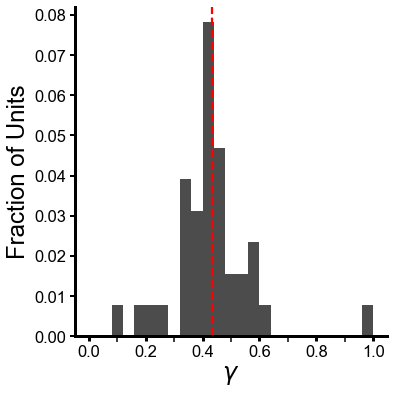

In [67]:
dwidth = .04
fig, ax = plt.subplots(1,figsize=(6,6))
gammas = GLM_VisMov_AddMul['gamma_trace_all'][:,-1][r2_sig2]
count,edges = np.histogram(gammas, bins=np.arange(0,1+dwidth,dwidth))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/data['model_nsp'].shape[-1],color='k',width=dwidth, alpha=.7)
ax.axvline(x=np.nanmean(gammas),c='r',ls='--')
# ax.set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
ax.set_xlabel('$\gamma$', fontsize=fontsize)
ax.set_ylabel('Fraction of Units', fontsize=fontsize)
# ax.set_yticks(np.arange(0,.2,.05))
# ax.set_ylim(0,.1)
ax.set_xticks(np.arange(.1,1.1,.2), minor=True)
plt.tight_layout()
# fig.savefig(fig_dir/'Gamma_Hist_binlen{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight', dpi=300)

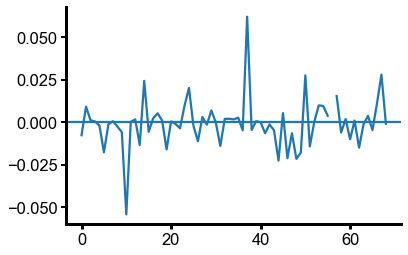

In [9]:
plt.plot(xvals - yvals)
plt.axhline(y=0)

In [ ]:
celln = 126
plt.plot(GLM_VisMov_Add['loss_regcv'][0,:,celln])
plt.plot(GLM_VisMov_Mul['loss_regcv'][0,:,celln])

## Comparison Plots

In [80]:
save_pdf = True

ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
spk_percentile2 = np.arange(.125,1.125,.25)

fontsize = 24
Kfold = 0
Nepochs = 5000
move_train,mov_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000,Kfold))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs,Kfold))
GLM_VisMov_AddMul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_AddMul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 10000,Kfold))
locals().update(params)

# pbar = tqdm([21,25,49,51,61,62,88,117,121,126]) # [12,13,20,25,49,51]) # 
pbar = tqdm(np.arange(model_nsp.shape[-1]))
pdf_name = fig_dir/ 'VisMov_{}_dt{:03d}_Lags{:02d}_Kfold{:02d}_CellSummary.pdf'.format('Pytorch_VisMov_AddMul',int(params['model_dt']*1000),params['nt_glm_lag'],Kfold)
if save_pdf:
    pdf = PdfPages(pdf_name)
for n, celln in enumerate(pbar): 
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(params['nt_glm_lag'])])
    axs3a = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    f2_ax6 = fig2.add_subplot(spec2[1, :params['nt_glm_lag']//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (params['nt_glm_lag']//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    f2_ax8b = fig2.add_subplot(spec2[2,-1])
    if MovModel != 0:
        crange = np.max(np.abs(GLM_VisMov_Add['sta_all'][celln]))
        crange2 = np.max(np.abs(GLM_VisMov_Mul['sta_all'][celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_VisMov_Add['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(GLM_VisMov_Add['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_AddMul = ((np.convolve(GLM_VisMov_AddMul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'g', lw=2,label='Vis')
    f2_ax6.plot(np.arange(len(pred_smooth_Add))*model_dt,pred_smooth_Add,'b', lw=2, label='Vis+Mov')
    f2_ax6.plot(np.arange(len(pred_smooth_Mul))*model_dt,pred_smooth_Mul,'r', lw=2, label='Vis*Mov')
    f2_ax6.plot(np.arange(len(pred_smooth_AddMul))*model_dt,pred_smooth_AddMul,'c', lw=2, label='Vis*Mov&Vis+Mov')
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax6.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
    r2_Vis = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
    r2_Add = (np.corrcoef(sp_smooth,pred_smooth_Add)[0,1])**2
    r2_Mul = (np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1])**2
    r2_AddMul = (np.corrcoef(sp_smooth,pred_smooth_AddMul)[0,1])**2
    

    # f2_ax7.plot(GLM_VisMov_Vis['tloss_trace_all'][celln],label='Vis Tr')
    # f2_ax7.plot(GLM_VisMov_Add['tloss_trace_all'][celln],label='Vis+Mov Tr')
    # f2_ax7.plot(GLM_VisMov_Mul['tloss_trace_all'][celln],label='Vis*Mov Tr')
    f2_ax7.plot(GLM_VisMov_Vis['vloss_trace_all'][celln], label='Vis Te')
    f2_ax7.plot(GLM_VisMov_Add['vloss_trace_all'][celln], label='Vis+Mov Te')
    f2_ax7.plot(GLM_VisMov_Mul['vloss_trace_all'][celln], label='Vis*Mov Te')
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    f2_ax7.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0, fancybox=True)

    w_move_Add = GLM_VisMov_Add['w_move']
    w_move_Mov = GLM_VisMov_Mul['w_move']
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move_Add[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
        f2_ax8.set_title('Add Weights')
        f2_ax8b.bar(modeln, w_move_Mov[celln,modeln], color=clrs[modeln])
        f2_ax8b.set_xticks(np.arange(0,len(titles)))
        f2_ax8b.set_xticklabels(titles)
        f2_ax8b.set_ylabel('GLM Weight')
        f2_ax8b.set_title('Mul Weights')


    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs3a[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

        axs3a[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs3a[modeln].set_xlim(-30,30)
        axs3a[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs3a[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs3a[modeln].set_title(titles[modeln],fontsize=fontsize)

    gamma = GLM_VisMov_AddMul['gamma_trace_all'][celln,-1]
    plt.suptitle(' celln: {}\n Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f}, AddMul $r^2$:{:.03f} $\gamma${:.02f}'.format(celln,r2_Vis,r2_Add,r2_Mul,r2_AddMul,gamma))
    plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()


<>:102: DeprecationWarning: invalid escape sequence \g
<>:102: DeprecationWarning: invalid escape sequence \g
/tmp/ipykernel_286731/3408320832.py:102: DeprecationWarning: invalid escape sequence \g
  plt.suptitle(' celln: {}\n Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f}, AddMul $r^2$:{:.03f} $\gamma${:.02f}'.format(celln,r2_Vis,r2_Add,r2_Mul,r2_AddMul,gamma))


Done Loading Unaligned data


  0%|          | 0/128 [00:00<?, ?it/s]

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid 

## Check Summary Plot

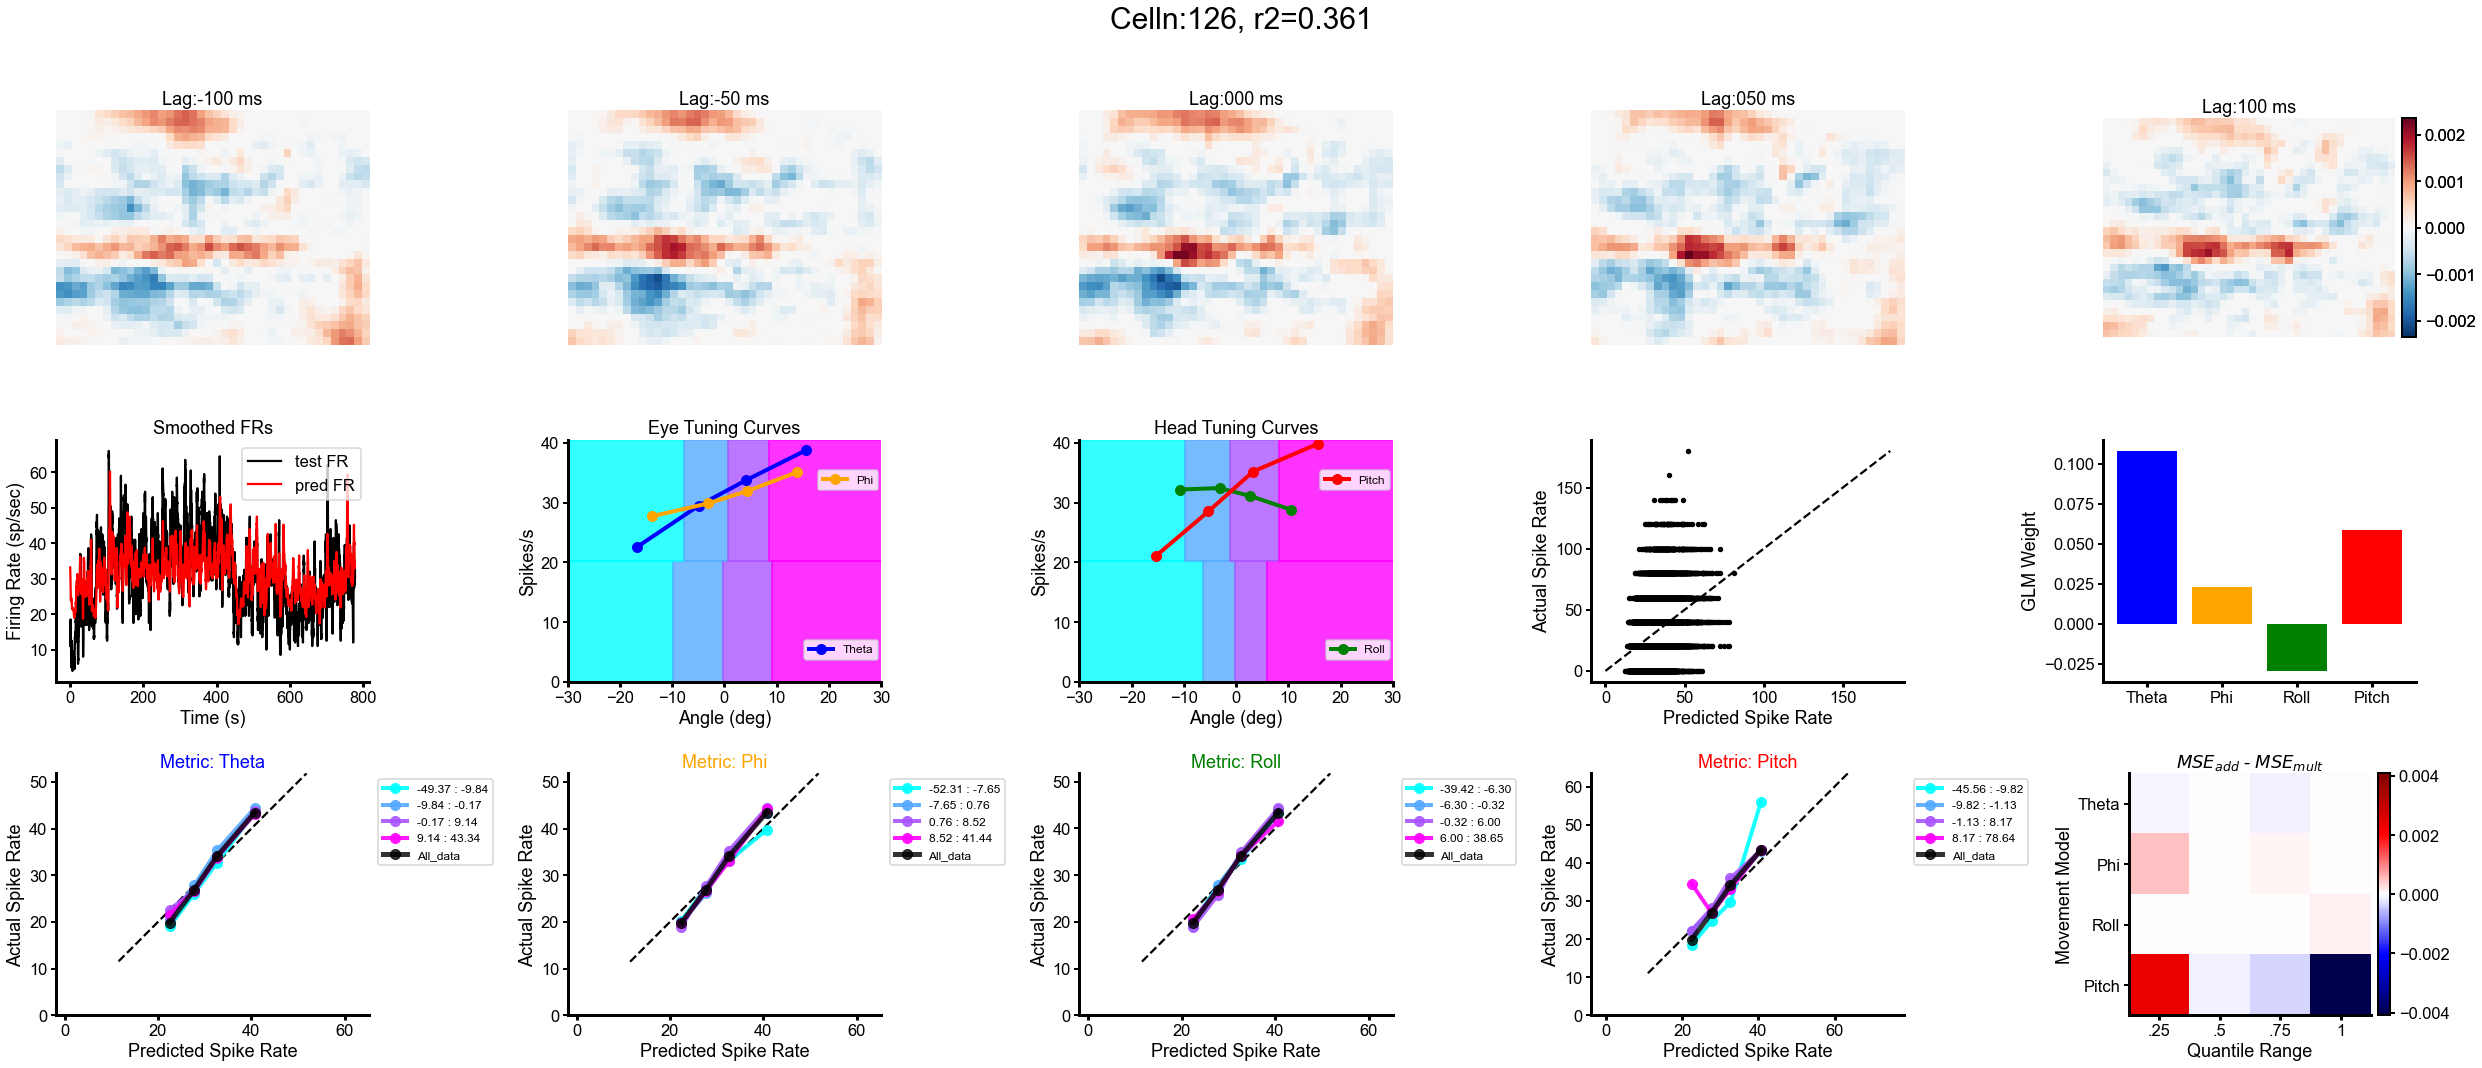

In [5]:
celln = 126 # np.argmax(r2_test)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))
MovModel=2
locals().update(GLM_VisMov_Mul)
fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

dataset_type = 'train'

if dataset_type == 'train':
    predcell = pred_train[:,celln]/model_dt
    nspcell = train_nsp[:,celln]/model_dt
    nsp_raw = train_nsp[:,celln]
    pred_raw = pred_train[:,celln]
    move_data = move_train.copy()
else: 
    predcell = pred_test[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    nsp_raw = test_nsp[:,celln]
    pred_raw = pred_test[:,celln]
    move_data = move_test.copy()

nsp_smooth=((np.convolve(nsp_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth=((np.convolve(pred_raw, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]


# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(np.arange(len(nsp_smooth))*model_dt,nsp_smooth,'k',label='test FR')
axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Firing Rate (sp/sec)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(sta_all[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle (deg)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_data[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw,statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    # cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    # norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle (deg)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(predcell,nspcell,c='k',s=15)
axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],params['nt_glm_lag'],len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[1,4].set_xticks(np.arange(0,len(titles)))
    axs[1,4].set_xticklabels(titles)
    axs[1,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_data[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
    axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)
#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
    axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_test[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)


In [ ]:
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
fontsize=24
dataset_type = 'test'
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5
if dataset_type == 'train':
    predcell = pred_train[:,celln]/model_dt
    nspcell = train_nsp[:,celln]/model_dt
    nsp_raw = train_nsp.copy()
    pred_raw = pred_train.copy()
    move_data = move_train.copy()
else: 
    predcell = pred_test[:,celln]/model_dt
    nspcell = test_nsp[:,celln]/model_dt
    nsp_raw = test_nsp.copy()
    pred_raw = pred_test.copy()
    move_data = move_test.copy()
    
for n, celln in enumerate(tqdm([21,25,49,51,61,88,117,121,126])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    # axs = np.array([fig2.add_subplot(spec2[0, :])])
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (nt_glm_lag//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    axs2 = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(nsp_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all2[celln])
    f2_ax7.plot(vloss_trace_all2[celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],params['nt_glm_lag'],len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    
    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs2[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

        axs2[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs2[modeln].set_xlim(-30,30)
        axs2[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs2[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs2[modeln].set_title(titles[modeln],fontsize=fontsize)
#         axs2[modeln].set_yticks(np.arange(0,top_yaxs,10).astype(int))
        
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [26]:
save_dir_hf = save_dir.parent / 'hf1_wn'

In [27]:
GLM_VisMov_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))

## Tuning Histograms

<>:11: DeprecationWarning: invalid escape sequence \{
<>:11: DeprecationWarning: invalid escape sequence \{
/tmp/ipykernel_520087/606694293.py:11: DeprecationWarning: invalid escape sequence \{
  ax[modeln].set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)


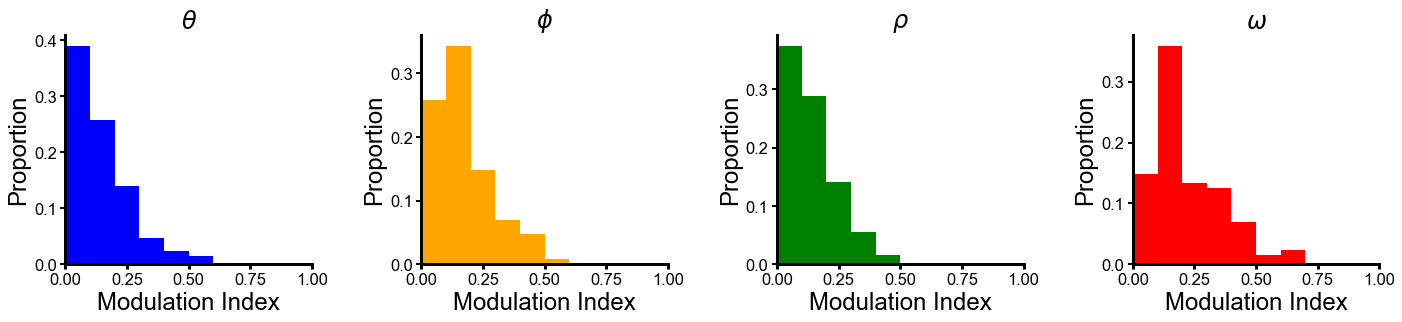

In [145]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax = ax.flatten()
dwidth = .1
for modeln in np.arange(len(titles)):
    count,edges = np.histogram(tuning_sig[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax[modeln].bar(edges_mid, count/len(tuning_sig[:,modeln]),color=clrs[modeln],width=dwidth)
    ax[modeln].set_title('$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
    ax[modeln].set_xlabel('Modulation Index', fontsize=fontsize)
    ax[modeln].set_ylabel('Proportion', fontsize=fontsize)
    ax[modeln].set_xlim(0,1)
#     ax[modeln].set_ylim(0,.2)
plt.tight_layout()
fig.savefig(fig_dir/'Modulation_hist.pdf',facecolor='white', transparent=True, bbox_inches='tight')

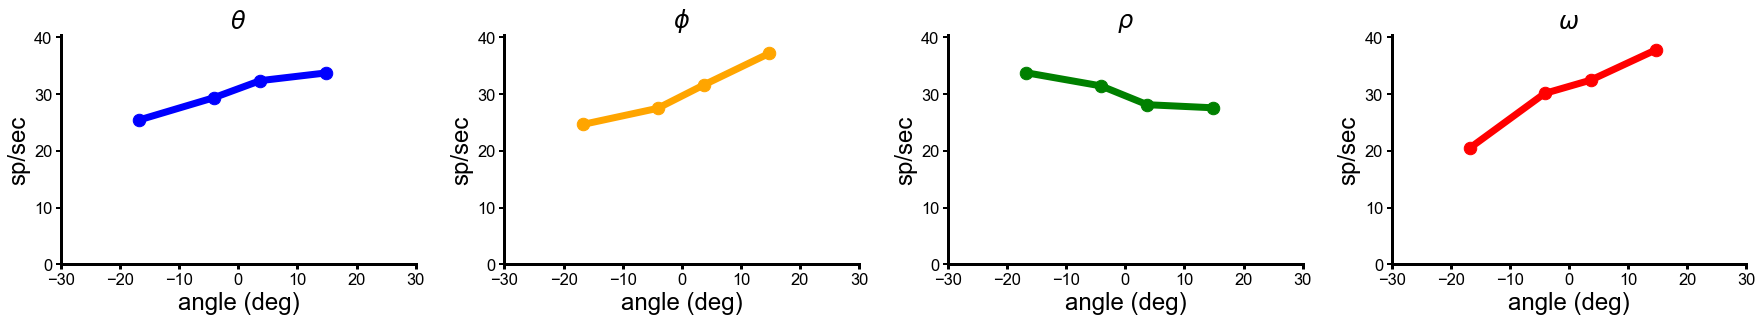

In [18]:
celln = 126
fontsize = 24
fig, axs = plt.subplots(1,4, figsize=(25,5))
# Tuning Curves
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[:,modeln]
    axs[modeln].plot(edge_mids,tuning_curves[celln,modeln],'.-', ms=25, lw=7,c=clrs[modeln])
    axs[modeln].set_xlim(-30,30)
    axs[modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs[modeln].set_title(r'$\{}$'.format(titles[modeln]),fontsize=fontsize)
    axs[modeln].set_ylim(bottom=0,top=np.nanmax(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
plt.tight_layout()
fig.savefig(fig_dir/'Turning_Curve_cell{}.pdf'.format(celln),facecolor='white', transparent=True, bbox_inches='tight')

## HF Vs FM RFs

In [6]:
Nepochs = 12000
Kfold = 0
GLM_VisMov_Vis = ioh5.load(save_dir_fm/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs, Kfold))
GLM_VisMov_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
sta_FM = GLM_VisMov_Vis['sta_all'][:,2,10:,:-10]
sta_HF = GLM_VisMov_HF['sta_all'][:,2,10:,:-10]

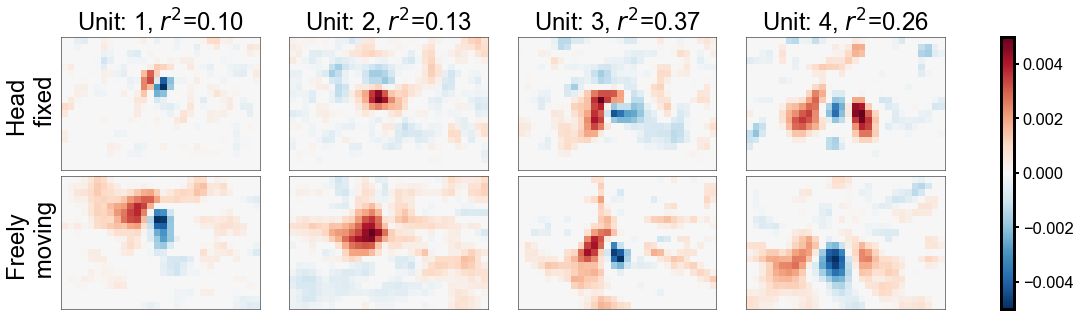

In [29]:

cells = [25,45,70,117] # 
num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    crange1 = np.max(np.abs(sta_HF[cell]))
    im1 = axs1[0,n].imshow(sta_HF[cell], 'RdBu_r', vmin=-crange1, vmax=crange1)
    r2_up = np.corrcoef(sta_HF[cell].flatten(),sta_FM[cell].flatten())[0,1]**2
    axs1[0,n].set_title('Unit: {}, $r^2$={:.02f}'.format(n+1,r2_up), fontsize=fontsize)
    crange2 = np.max(np.abs(sta_FM[cell]))
    im2 = axs1[1,n].imshow(sta_FM[cell],'RdBu_r', vmin=-crange2, vmax=crange2)

axs1[0,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[1,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
# cbar2.set_ticks([-crange2, crange2])
# cbar2.set_ticklabels(['Dark', 'Light'])
# cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])    
# fig1.savefig(fig_dir/'HF_FM_RFComparison.pdf', facecolor='white', transparent=True, bbox_inches='tight')

In [92]:
celln = 117
np.corrcoef(sta_HF[celln].reshape(-1),sta_FM[celln].reshape(-1))[0,1]**2, np.corrcoef(HF_sta_up[celln].reshape(-1),FM_sta_up[celln].reshape(-1))[0,1]**2

(0.2554321873083842, 0.15781810523797482)

In [9]:
sf = 4
FM_sta_up = np.zeros((GLM_VisMov_Vis['sta_all'].shape[0], GLM_VisMov_Vis['sta_all'].shape[1],sf*GLM_VisMov_Vis['sta_all'].shape[-2], sf*GLM_VisMov_Vis['sta_all'].shape[-1]))
HF_sta_up = np.zeros((GLM_VisMov_HF['sta_all'].shape[0], GLM_VisMov_HF['sta_all'].shape[1], sf*(GLM_VisMov_HF['sta_all'].shape[-2]), sf*(GLM_VisMov_HF['sta_all'].shape[-1])))
for n in range(GLM_VisMov_HF['sta_all'].shape[0]):
    for t in range(GLM_VisMov_HF['sta_all'].shape[1]):
        HF_sta_up[n, t] = cv2.resize(GLM_VisMov_HF['sta_all'][n, t], (sf*(GLM_VisMov_HF['sta_all'].shape[-1]), sf*(GLM_VisMov_HF['sta_all'].shape[-2])))
for n in range(GLM_VisMov_Vis['sta_all'].shape[0]):
    for t in range(GLM_VisMov_Vis['sta_all'].shape[1]):
        FM_sta_up[n, t] = cv2.resize(GLM_VisMov_Vis['sta_all'][n, t], (sf*GLM_VisMov_Vis['sta_all'].shape[-1], sf*GLM_VisMov_Vis['sta_all'].shape[-2]))


In [10]:
celln = 49
r2_HFFM_sta = np.zeros(model_nsp.shape[-1])
for celln in np.arange(model_nsp.shape[-1]):
    r2_HFFM_sta[celln] = np.corrcoef(sta_HF[celln].flatten(),sta_FM[celln].flatten())[0,1]

In [38]:
np.argmax(r2_HFFM_sta)

74

In [13]:
thresh_fr = 1
r2_thresh=.05
# r2_sigP = np.nanmean(r2_Mot,axis=0)
r2_sigV = np.nanmean(r2_Vis,axis=0)
r2_sig2 = (r2_sigV>r2_thresh) & (avg_fr>thresh_fr)
r2_idx = np.where(r2_sig2)[0]
np.sum(r2_sig2)

/tmp/ipykernel_320313/220280902.py:4: RuntimeWarning: Mean of empty slice
  r2_sigV = np.nanmean(r2_Vis,axis=0)


82

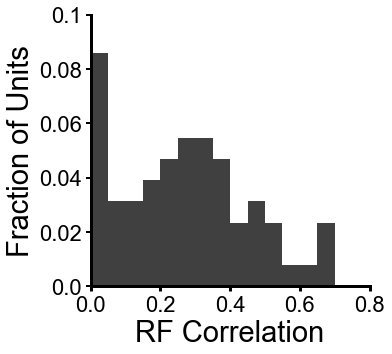

In [16]:

hbins=.05
fontsize=24
fig, ax = plt.subplots(figsize=(5,5))
count,edges = np.histogram(r2_HFFM_sta[r2_sig2],bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(r2_HFFM_sta),color='k',width=hbins, alpha=.75)
ax.set_xlabel('RF Correlation',fontsize=fontsize+5)
ax.set_ylabel('Fraction of Units',fontsize=fontsize+5)
ax.set_yticks(np.arange(0,1,.02))
ax.set_yticklabels(np.round(np.arange(0,1,.02),decimals=3),fontsize=fontsize-2)
ax.set_xticks(np.arange(0,1,.2))
ax.set_xticklabels(np.round(np.arange(0, 1, .2),decimals=1), fontsize=fontsize-2)
ax.set_xlim(0,.8)
ax.set_ylim(0,.1)
fig.savefig(fig_dir/'HFFM_RF_CCHist.pdf', facecolor='white', transparent=True, bbox_inches='tight')


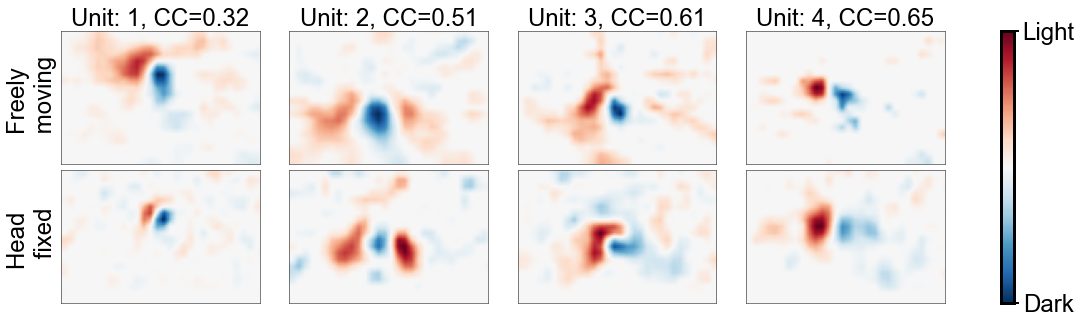

In [16]:

cells = [25,117,70,90] # 
num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    r2_up = np.corrcoef(sta_HF[cell].flatten(),sta_FM[cell].flatten())[0,1]
    crange2 = np.max(np.abs(FM_sta_up[cell,2,int(sf*10):,:-int(sf*10)]))
    im2 = axs1[0,n].imshow(FM_sta_up[cell, 2,int(sf*10):,:-int(sf*10)],'RdBu_r', vmin=-crange2, vmax=crange2)
    crange1 = np.max(np.abs(HF_sta_up[cell,2,int(sf*10):,:-int(sf*10)]))
    im1 = axs1[1,n].imshow(HF_sta_up[cell, 2,int(sf*10):,:-int(sf*10)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs1[0,n].set_title('Unit: {}, CC={:.02f}'.format(n+1,r2_up), fontsize=fontsize)

axs1[1,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im1, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange1, crange1])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])    
fig1.savefig(fig_dir/'HF_FM_RF_CCComparison.pdf', facecolor='white', transparent=True, bbox_inches='tight')

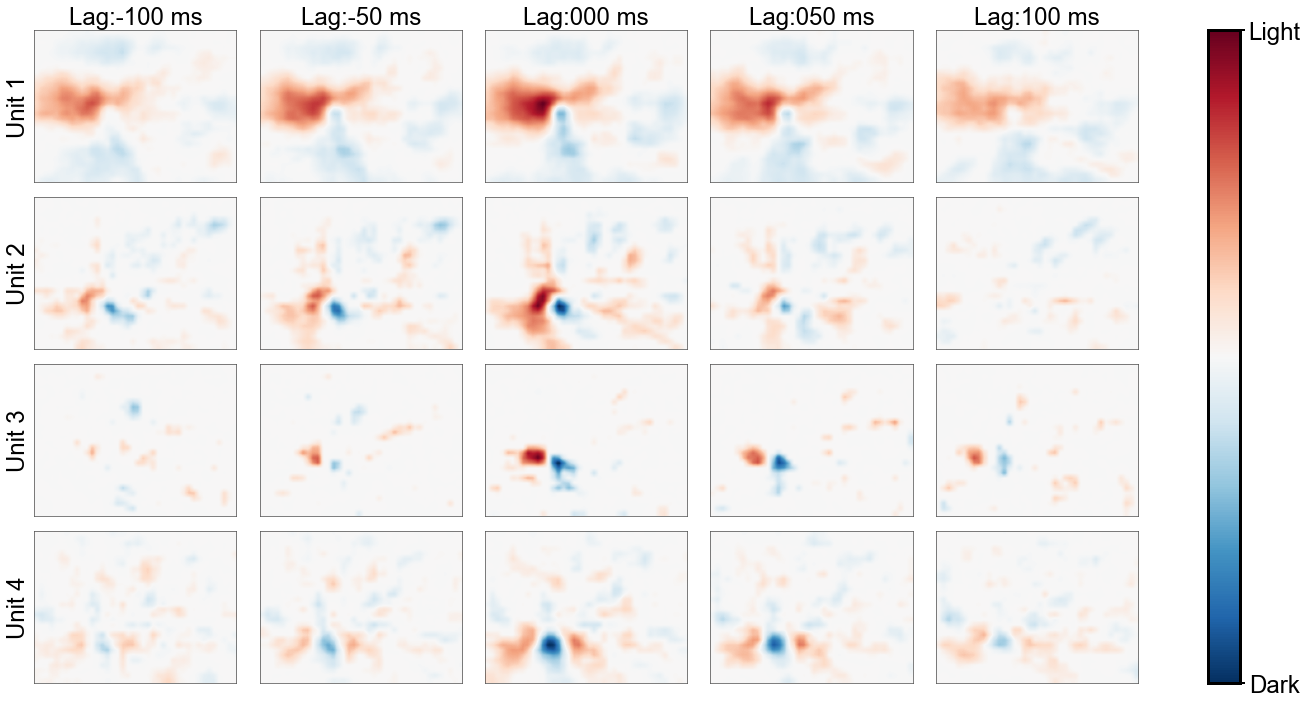

In [18]:
cells = [25,70,90,117] # 49
num_cells = len(cells)

fig1 = plt.figure(constrained_layout=False, figsize=(int(5*nt_glm_lag),int(3*num_cells)))
spec2 = gridspec.GridSpec(ncols=params['nt_glm_lag'], nrows=num_cells, figure=fig1, wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(num_cells) for m in range(nt_glm_lag)]).reshape(num_cells,nt_glm_lag)
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(FM_sta_up[cell]))
    for lag in range(nt_glm_lag):
        im2 = axs1[n,lag].imshow(FM_sta_up[cell, lag],'RdBu_r', vmin=-crange2, vmax=crange2)
        axs1[0,lag].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[lag]*model_dt)),fontsize=fontsize)
    axs1[n,0].set_ylabel('Unit {}'.format(n+1),fontsize=fontsize)
cbar2 = fig.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# fig1.savefig(fig_dir/'Example_FM_RFs.png', facecolor='white', transparent=True, bbox_inches='tight')
# print('Saved to: {}'.format(FigPath_SFN/'FM_RFs.png'))

In [129]:
np.sum(r2_HFFM_sta>.09)/128

0.3203125

In [125]:
GLM_VisMov_HF['r2_test'][r2_HFFM_sta>.09].shape[0],GLM_VisMov_HF['r2_test'].shape[0]

(41, 128)

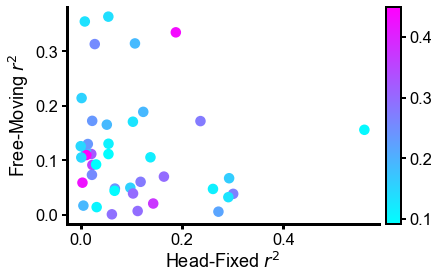

In [131]:
fig, ax = plt.subplots()
im=ax.scatter(GLM_VisMov_HF['r2_test'][r2_HFFM_sta>.09],GLM_VisMov_Vis['r2_test'][r2_HFFM_sta>.09],c=r2_HFFM_sta[r2_HFFM_sta>.09],cmap='cool')
ax.set_xlabel('Head-Fixed $r^2$')
ax.set_ylabel('Free-Moving $r^2$')
cbar = add_colorbar(im)

In [ ]:

cells = np.argpartition(r2_HFFM_sta, -127)[-127:]
num_cells = len(cells)
fontsize=24
# fig_dir_presentations = check_path(fig_dir,'PaperFigs') #UT_Austin_Talk

# fig1, axs1 = plt.subplots(2,2,figsize=(10,5),)
fig1 = plt.figure(constrained_layout=False, figsize=(int(5*num_cells),5))
spec2 = gridspec.GridSpec(ncols=num_cells, nrows=2, figure=fig1, wspace=.1,hspace=.05)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
for n, cell in enumerate(cells):
    crange1 = np.max(np.abs(HF_sta_up[cell,2,int(sf*10):,:-int(sf*10)]))
    im1 = axs1[0,n].imshow(HF_sta_up[cell, 2,int(sf*10):,:-int(sf*10)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    r2_up = np.corrcoef(sta_HF[cell].flatten(),sta_FM[cell].flatten())[0,1]**2
    axs1[0,n].set_title('Unit: {}, $r^2$={:.02f}'.format(cell,r2_up), fontsize=fontsize)
    crange2 = np.max(np.abs(FM_sta_up[cell,2,int(sf*10):,:-int(sf*10)]))
    im2 = axs1[1,n].imshow(FM_sta_up[cell, 2,int(sf*10):,:-int(sf*10)],'RdBu_r', vmin=-crange2, vmax=crange2)

axs1[0,0].set_ylabel('Head \n fixed', fontsize=fontsize)
axs1[1,0].set_ylabel('Freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])    
fig1.savefig(fig_dir/'HF_FM_RFComparison_sorted.pdf', facecolor='white', transparent=True, bbox_inches='tight')

### HF predicts FM

In [38]:
params['free_move']=False
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)

Done Loading Unaligned data


In [3]:
Nepochs = 12000
Kfold = 0
GLM_VisMov_Vis = ioh5.load(save_dir_fm/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs, Kfold))
GLM_VisMov_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
w_FM = torch.from_numpy(GLM_VisMov_Vis['sta_all'].reshape(GLM_VisMov_Vis['sta_all'].shape[0],-1)).to(device)
w_HF = torch.from_numpy(GLM_VisMov_HF['sta_all'].reshape(GLM_VisMov_HF['sta_all'].shape[0],-1)).to(device)

In [29]:

l1 = PoissonGLM_AddMult(input_size,output_size,
                        reg_alph=None,reg_alphm=None,move_features=None,
                        meanfr=meanbias,init_sta=w_FM,
                        train_shifter=False,
                        LinMix=False,NonLinLayer=False, device=device,).to(device)


# GLM_Network = GLM_VisMov_HF
# key_list = ['sta_all','bias', 'w_move','biasm']

# param_dict = {}
# for (pname, param),key in zip(l1.named_parameters(),key_list):
#     if key == 'sta_all':
#         param_dict[pname] = torch.from_numpy(GLM_Network[key].reshape(data['model_nsp'].shape[-1],-1).astype(np.float32))
#     else: 
#         param_dict[pname] = torch.from_numpy(GLM_Network[key].astype(np.float32))
# l1.load_state_dict(param_dict)

In [30]:
out = l1(xtr, xtrm,shift_in_tr)
loss = l1.loss(out, ytr)
pred = l1(xte, xtem,shift_in_te)
val_loss = l1.loss(pred, yte)
pred_test2 = pred.detach().cpu().numpy()

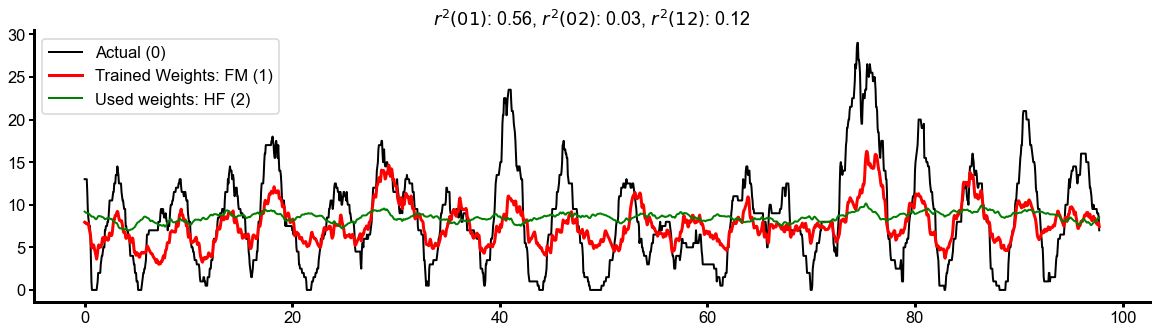

In [44]:
celln = 25
bin_length=40
fig,ax = plt.subplots(figsize=(20,5))
GLM_Network = GLM_VisMov_HF # GLM_VisMov_Vis #
sp_smooth = ((np.convolve(GLM_Network['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth1 = ((np.convolve(GLM_Network['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
# sp_smooth = (sp_smooth-np.nanmean(sp_smooth))/np.max(sp_smooth-np.nanmean(sp_smooth))
# pred_smooth_Vis = (pred_smooth_Vis-np.nanmean(pred_smooth_Vis))/np.max(pred_smooth_Vis-np.nanmean(pred_smooth_Vis))
# pred_smooth1 = (pred_smooth1-np.nanmean(pred_smooth1))/np.max(pred_smooth1-np.nanmean(pred_smooth1))


ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
ax.plot(np.arange(len(pred_smooth1))*params['model_dt'],pred_smooth1,'r', lw=3)
ax.plot(np.arange(len(pred_smooth2))*params['model_dt'],pred_smooth2,'g', lw=2)
r2_01 = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
r2_02 = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
r2_12 = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2
ax.set_title('$r^2 (01)$: {:.02f}, $r^2 (02)$: {:.02f}, $r^2 (12)$: {:.02f} '.format(r2_01,r2_02,r2_12))
ax.legend(['Actual (0)','Trained Weights: FM (1)', 'Used weights: HF (2)'], loc='upper left')
fig.savefig(fig_dir/'HFData_FMW_Cell{}.png'.format(celln), facecolor='white', transparent=True, bbox_inches='tight')

In [27]:
# FM Data HF Weights
r2_HM_FM2 = np.zeros((3,output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth1 = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_HM_FM2[0,celln] = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
    r2_HM_FM2[1,celln] = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
    r2_HM_FM2[2,celln] = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [33]:
r2_HM_FM = np.zeros((3,output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(GLM_VisMov_HF['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth1 = ((np.convolve(GLM_VisMov_HF['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth2 = ((np.convolve(pred_test2[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_HM_FM[0,celln] = np.corrcoef(sp_smooth,pred_smooth1)[0,1]**2
    r2_HM_FM[1,celln] = np.corrcoef(sp_smooth,pred_smooth2)[0,1]**2
    r2_HM_FM[2,celln] = np.corrcoef(pred_smooth1,pred_smooth2)[0,1]**2

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [39]:
thresh = .09

inds = r2_HFFM_sta>thresh

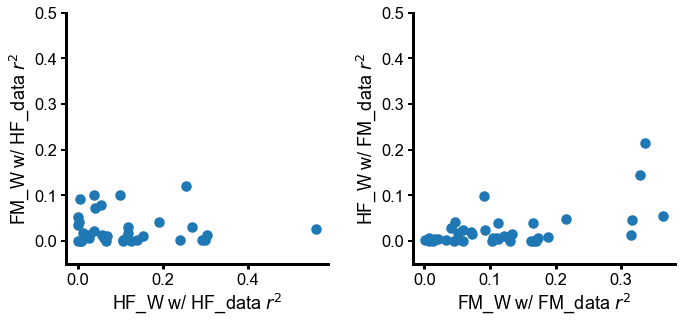

In [40]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(r2_HM_FM[0,inds],r2_HM_FM[1,inds])
axs[0].set_xlabel('HF_W w/ HF_data $r^2$')
axs[0].set_ylabel('FM_W w/ HF_data $r^2$')
axs[0].set_ylim(-.05,.5)

axs[1].scatter(r2_HM_FM2[0,inds],r2_HM_FM2[1,inds])
axs[1].set_xlabel('FM_W w/ FM_data $r^2$')
axs[1].set_ylabel('HF_W w/ FM_data $r^2$')
axs[1].set_ylim(-.05,.5)
plt.tight_layout()
fig.savefig(fig_dir/'SwappingWeights.png', facecolor='white', transparent=True, bbox_inches='tight')

### Testing Gabors

In [ ]:

def gabor(sigma, theta, Lambda, psi, gamma):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    # (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
    (y, x) = np.meshgrid(np.arange(-15, 15 + 1), np.arange(-10, 10 + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

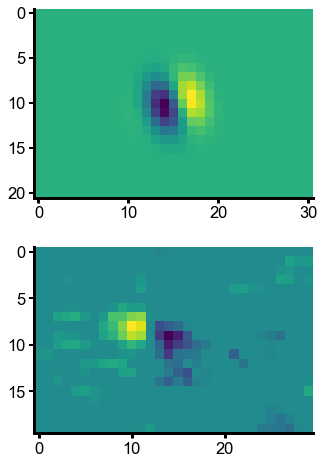

In [ ]:
celln = 90
gb = gabor(2,5,10,2,1)
fig,axs = plt.subplots(2,1,figsize=(5,8))
axs[0].imshow(gb)
axs[1].imshow(sta_FM[celln])

# Position FR Plots

In [7]:
GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 12000))
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs))


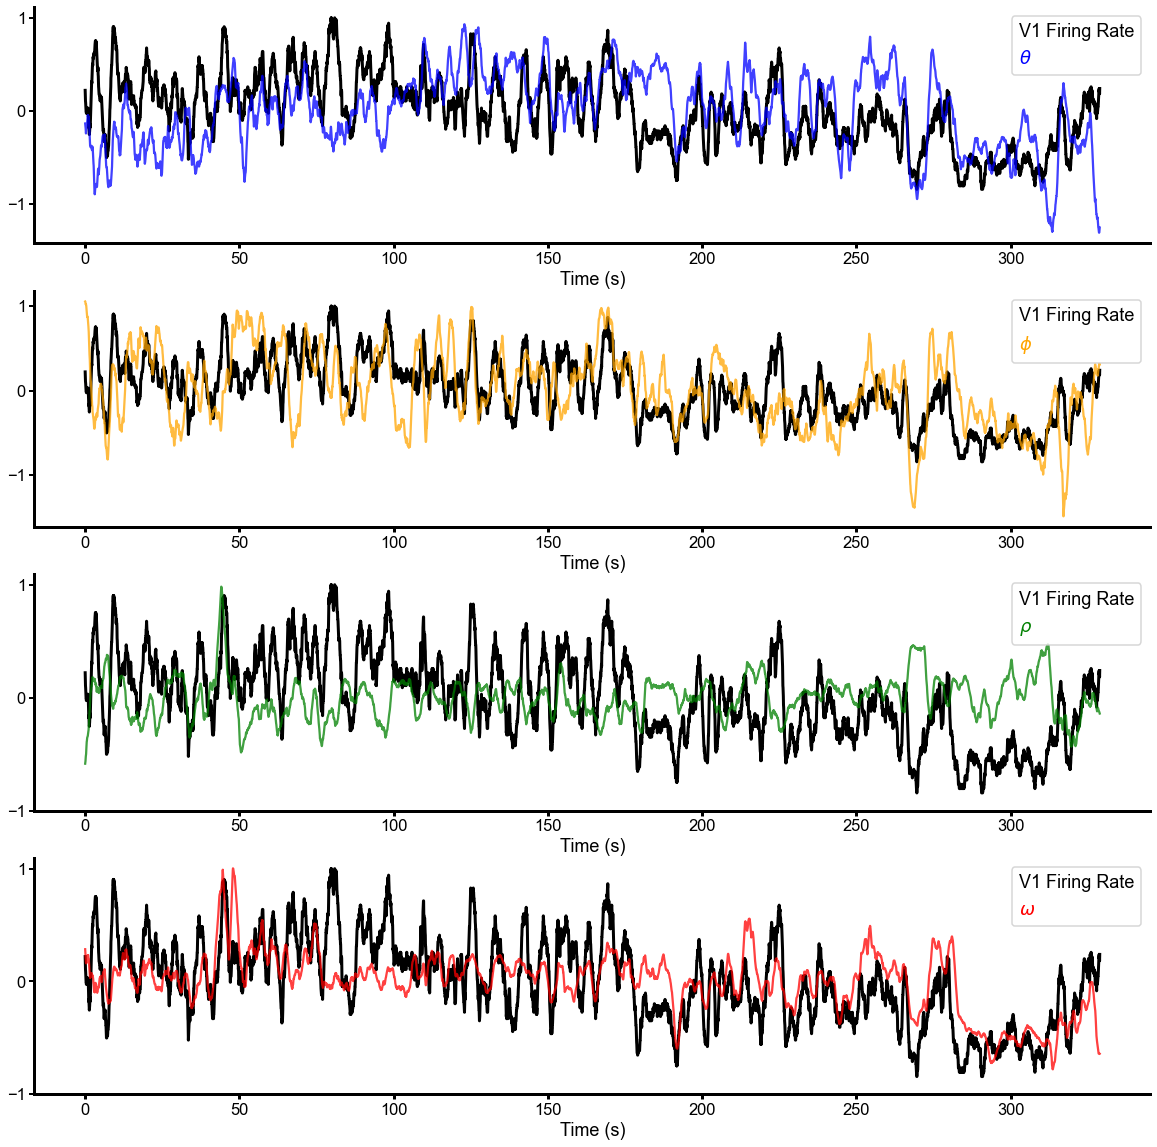

In [7]:
celln = 126
bin_length=40
titles = np.array(['theta', 'phi', 'rho', 'omega'])
clrs = ['blue', 'orange', 'green', 'red']

fig, axs = plt.subplots(4,1,figsize=(20,20))
for modeln in np.arange(len(titles)):
    ax = axs[modeln]
    sp_smooth = ((np.convolve(GLM_VisMov_Add['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    ax.plot(np.arange(len(sp_smooth))*model_dt, (sp_smooth-np.mean(sp_smooth)) /np.max(sp_smooth-np.mean(sp_smooth)), 'k', lw=3, label='V1 Firing Rate')
    # ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,(pred_smooth_Vis-np.mean(pred_smooth_Vis))/np.max(pred_smooth_Vis),'g', lw=2,label='Vis')
    # ax.plot(np.arange(len(pred_smooth_Add))*model_dt,(pred_smooth_Add-np.mean(pred_smooth_Add))/np.max(pred_smooth_Add),'b', lw=2, label='Vis+Mov')
    # ax.plot(np.arange(len(pred_smooth_Mul))*model_dt,(pred_smooth_Mul-np.mean(pred_smooth_Mul))/np.max(pred_smooth_Mul),'r', lw=2, label='Vis*Mov')
    smooth_move = np.zeros((len(titles), sp_smooth.shape[0]))
    smooth1 = ((np.convolve(move_test[:,modeln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move[modeln] = (smooth1 - np.nanmean(smooth1))/np.max(smooth1)
    ax.plot(np.arange(smooth_move[modeln].shape[0])*model_dt, smooth_move[modeln],c=clrs[modeln], label=r'$\{}$'.format(titles[modeln]),alpha=.75)
    ax.set_xlabel('Time (s)')
    ax.set_yticks(np.arange(-1,2,1))
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0)


# HeadFixed Plots

In [ ]:

ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
fontsize = 24
MovModel=1
GLM_VisMov_HF = ioh5.load(save_dir_hf/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}.h5'.format('Pytorch_Vis_NoL1',int(params['model_dt']*1000), params['nt_glm_lag'], 1, Nepochs))
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
fontsize=24
dataset_type = 'test'
stat_bins = 5

if dataset_type == 'train':
    predcell = GLM_VisMov_HF['pred_train'][:,celln]/model_dt
    nspcell = GLM_VisMov_HF['train_nsp'][:,celln]/model_dt
    nsp_raw = GLM_VisMov_HF['train_nsp'].copy()
    pred_raw = GLM_VisMov_HF['pred_train'].copy()
    move_data = move_train.copy()
else: 
    predcell = GLM_VisMov_HF['pred_test'][:,celln]/model_dt
    nspcell = GLM_VisMov_HF['test_nsp'][:,celln]/model_dt
    nsp_raw = GLM_VisMov_HF['test_nsp'].copy()
    pred_raw = GLM_VisMov_HF['pred_test'].copy()
    move_data = move_test.copy()
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5
for n, celln in enumerate(tqdm([21,25,49,51,61,88,117,121,126])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    # axs = np.array([fig2.add_subplot(spec2[0, :])])
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (nt_glm_lag//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    axs2 = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    
    if MovModel != 0:
        crange = np.max(np.abs(GLM_VisMov_HF['sta_all'][celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_VisMov_HF['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(nsp_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_raw[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(GLM_VisMov_HF['tloss_trace_all'][celln])
    f2_ax7.plot(GLM_VisMov_HF['vloss_trace_all'][celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],params['nt_glm_lag'],len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    
    # top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    # for i,modeln in enumerate(range(len(titles))):
    #     metric = move_data[:,modeln]
    #     nranges = np.quantile(metric,quartiles)
    #     stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
    #     edge_mids = np.quantile(metric,spk_percentile2)#
    #     # for m in range(len(nranges)-1):
    #     #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
    #     axs2[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

    #     axs2[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    #     axs2[modeln].set_xlim(-30,30)
    #     axs2[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
    #     axs2[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    #     axs2[modeln].set_title(titles[modeln],fontsize=fontsize)
#         axs2[modeln].set_yticks(np.arange(0,top_yaxs,10).astype(int))
        
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


# Shifter Training

In [3]:
args = arg_parser(jupyter=True)

MovModel = 1
LinMix = False
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# 012821/EE8P6LT
# 128: 070921/J553RT
# '110421/J569LT'# #'062921/G6HCK1ALTRN' '102621/J558NC'  # '110421/J569LT' #
date_ani = '070921/J553RT' #'102621/J558NC' #'110421/J569LT'  #  args['date_ani']
date_ani2 = '_'.join(date_ani.split('/'))
data_dir = Path(args['data_dir']).expanduser() / date_ani / stim_type
save_dir = (Path(args['save_dir']).expanduser() / date_ani / stim_type)
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_fm = save_dir.parent / 'fm1'
save_dir_hf = save_dir.parent / 'hf1_wn'
fig_dir = (Path(args['fig_dir']).expanduser()/'Encoding'/date_ani/stim_type)
fig_dir.mkdir(parents=True, exist_ok=True)
save_model = (save_dir / 'models' / '{}'.format(MovModel))
save_model.mkdir(parents=True, exist_ok=True)

file_dict = {'cell': 0,
        'drop_slow_frames': True,
        'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
        'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
        'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
        'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
        'mapping_json': Path('~/Research/Github/FreelyMovingEphys/probes/channel_maps.json').expanduser(),
        'mp4': True,
        'name': date_ani2 + '_control_Rig2_' + stim_type,  # 070921_J553RT
        'probe_name': 'DB_P128-6',
        'save': data_dir.as_posix(),
        'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
        'stim_type': 'light',
        'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
        'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }
params = {'Nepochs': args['Nepochs'],
        'model_dt': .05,
        'do_shuffle': False,
        'do_norm': False,
        'lag_list': np.array([0]),
        'free_move': free_move,
        'save_dir': save_dir,
        'data_dir': data_dir,
        'fig_dir': fig_dir,
        'save_model': save_model,
        'shiftn': 7, 
        'train_shifter': True,
        'MovModel': MovModel,
        'load_Vis' : True if MovModel==2 else False,
        'LinMix': args['LinMix'],
        'NKfold': args['NKfold'],
        }
params['nt_glm_lag']=len(params['lag_list'])
Nepochs = params['Nepochs']


if params['train_shifter']:
    save_model = save_model.parent / 'Shifter'
    save_model.mkdir(parents=True, exist_ok=True)
    params['save_model'] = save_model
    args['NoL1'] = True


params['WC_type'] = 'UC'
LinMix = params['LinMix']
if MovModel == 0:
    model_type = 'Pytorch_Mot'
elif MovModel == 1:
    model_type = 'Pytorch_Vis'
elif MovModel == 2:
    if LinMix:
        model_type = 'Pytorch_Add'
    else:
        model_type = 'Pytorch_Mul'
if args['NoL1']:
    model_type = model_type + '_NoL1'

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
titles_all = []
for n in range(1, len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))


Kfold = 0
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set up Train/Test Splits #####
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

avgfm_eye = np.load(save_dir_fm/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
if free_move:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1],data['train_roll'][:, np.newaxis], data['train_pitch'][:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1],data['test_roll'][:, np.newaxis], data['test_pitch'][:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1],data['model_roll'][:, np.newaxis], data['model_pitch'][:, np.newaxis]))
else:
    move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['train_phi'].shape)[:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis]))
    move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['test_phi'].shape)[:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis]))
    model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['model_phi'].shape)[:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis]))



##### Start GLM Parallel Processing #####
nks = np.shape(data['train_vid'])[1:]
nk = nks[0]*nks[1]*params['nt_glm_lag']
perms = np.array(list(itertools.combinations(np.arange(len(titles)), 4)))
# Reshape data (video) into (T*n)xN array
if params['train_shifter']:
    rolled_vid = np.hstack([np.roll(data['model_vid_sm'], nframes, axis=0) for nframes in params['lag_list']])  
    x_train = rolled_vid[train_idx].reshape((len(train_idx), 1)+nks).astype(np.float32)
    x_test = rolled_vid[test_idx].reshape((len(test_idx), 1)+nks).astype(np.float32)
    shift_in_tr = torch.from_numpy(move_train[:, (0, 1, 3)].astype(np.float32)).to(device)
    shift_in_te = torch.from_numpy(move_test[:, (0, 1, 3)].astype(np.float32)).to(device)
else:    
    model_vid_sm_shift = ioh5.load(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1))['model_vid_sm_shift{}'.format(params['shiftn'])]  # [:,5:-5,5:-5]
    nks = np.shape(model_vid_sm_shift)[1:]
    nk = nks[0]*nks[1]*params['nt_glm_lag']
    rolled_vid = np.hstack([np.roll(model_vid_sm_shift, nframes, axis=0) for nframes in params['lag_list']])  
    x_train = rolled_vid[train_idx].reshape(len(train_idx), -1)
    x_test = rolled_vid[test_idx].reshape(len(test_idx), -1)
    shift_in_tr = None
    shift_in_te = None


ytr = torch.from_numpy(data['train_nsp'].astype(np.float32)).to(device)
yte = torch.from_numpy(data['test_nsp'].astype(np.float32)).to(device)

input_size = nk
output_size = ytr.shape[1]

# Reshape data (video) into (T*n)xN array
if MovModel == 0:
    mx_train = move_train[:, perms[ind]]
    mx_test = move_test[:, perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)
    xtrm = None
    xtem = None
    nk = xtr.shape[-1]
    input_size = nk
    params['move_features'] = None 
    sta_init = torch.zeros((output_size, xtr.shape[-1]))
    params['lambdas'] = np.array([None])
    params['alphas'] = np.array([None])
    params['lambdas_m'] = np.array([None]) 
    params['alphas_m'] = np.array([None]) 
    nlam = len(params['lambdas'])
    nalph = len(params['alphas'])
    params['alphas_m'] = np.array(nalph*[None])
    params['lambdas_m'] = np.array([0])
    w_move_cv = np.zeros((nalph, nlam, output_size, nk))
    w_move_traces_all = np.zeros((nalph, nlam, params['Nepochs'], output_size, input_size))
    params['lr_w'] = [1e-5, 1e-3]
    params['lr_m'] = [1e-6, 1e-2]
    params['lr_b'] = [1e-6, 1e-2]
elif MovModel == 1:
    xtr = torch.from_numpy(x_train).to(device)
    xte = torch.from_numpy(x_test).to(device)
    xtrm = None
    xtem = None
    params['move_features'] = None
    sta_init = torch.zeros((output_size, input_size))
    params['alphas'] = np.array([.009 if args['NoL1']==False else None])
    params['lambdas'] = np.hstack((np.logspace(-3, 3.25, 10)[0], np.logspace(-3, 3.25, 20)))
    nlam = len(params['lambdas'])
    nalph = len(params['alphas'])
    params['lambdas_m'] = np.array(nlam*[None])
    params['alphas_m'] = np.array(nalph*[None])
    params['lr_w'] = [1e-5, 1e-3]
    params['lr_b'] = [1e-5, 5e-3]
elif MovModel == 2:
    xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
    xtrm = torch.from_numpy(move_train[:, perms[ind]].astype(np.float32)).to(device)
    xtem = torch.from_numpy(move_test[:, perms[ind]].astype(np.float32)).to(device)
    params['move_features'] = xtrm.shape[-1]
    sta_init = torch.zeros((output_size, input_size))
    params['alphas'] = np.array([None])
    params['lambdas'] =  np.hstack((np.logspace(-3, 3.25, 10)[0], np.logspace(-3, 3.25, 40)))
    nalph = len(params['alphas'])
    params['alphas_m'] = np.array(nalph*[None])
    params['lambdas_m'] = np.array([0]) # np.hstack((0, np.logspace(-5, 6, 40)))
    nlam = len(params['lambdas_m'])
    w_move_cv = np.zeros((nalph, nlam, output_size, params['move_features']))
    w_move_traces_all = np.zeros((nalph, nlam, Nepochs, output_size, params['move_features']))
    params['lr_w'] = [1e-5, 1e-3]
    params['lr_m'] = [1e-6, 5e-3]
    params['lr_b'] = [1e-6, 1e-2]

params['lr_shift'] = [1e-3,1e-1]
meanbias = torch.mean(torch.tensor(data['model_nsp'], dtype=torch.float32), axis=0)
params['Nepochs'] = params['Nepochs']
params['LinMix'] = LinMix
params['NonLinLayer'] = args['NonLinLayer']
params['Ncells'] = ytr.shape[-1]
print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:627: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Model: 1, move_features: None


In [3]:
hftofm_imu_file = '/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/110521_J569LT_control_Rig2_hf_to_fm_transfer_imu.nc'
imu_data = xr.open_dataset(hftofm_imu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
medfiltbins = 11
groll = medfilt(np.array(acc_chans.sel(channel='roll')),medfiltbins)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),medfiltbins)
eye_file = '/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn/070921_J553RT_control_Rig2_hf1_wn_REYE.nc'
eye_data = xr.open_dataset(eye_file)

eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)


(-15.195774273101321, 0.6804859823616609)

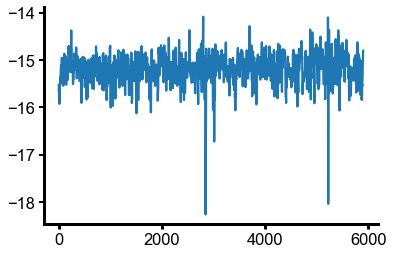

In [197]:
plt.plot(groll[100:6000])
np.mean(groll[100:6000]),np.mean(gpitch[100:6000])

In [3]:
fmimu_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*imu.nc'))[0]
imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*REYE.nc'))[0]
eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
# fm_eye = {'avg_th': np.nanmean(th),'avg_phi': np.nanmean(phi)}
# ioh5.save(save_dir/'FM_AvgEye_dt{:03d}.h5'.format(int(params['model_dt']*1000)),fm_eye)
fm_eye= np.array([np.nanmean(th),np.nanmean(phi)])
# np.save(save_dir/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)),fm_eye)

In [16]:
avgfm_eye

array([  8.30058505, -43.04876223])

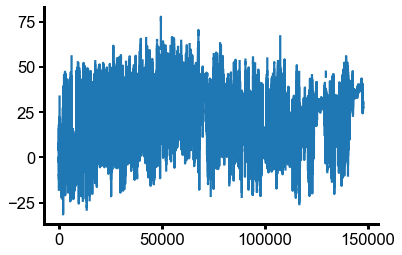

In [15]:
plt.plot(th)

In [5]:
reg_alph=a=0; l=7
l1 = PoissonGLM_AddMult(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        meanfr=meanbias,init_sta=sta_init,
                        train_shifter=params['train_shifter'],
                        NonLinLayer=False,
                        LinMix=False, device=device,).to(device)

l1.weight.shape,sta_init.shape

(torch.Size([102, 1200]), torch.Size([102, 1200]))

## Plot shift matricies

In [9]:
a = 0 
# save_model2 = save_model/'Shifter'
model_vid_sm_shift2 = {}
pdf_name = fig_dir/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary.pdf'.format('Pytorch_VisMov_AddMul_NoL1_Shifter',int(params['model_dt']*1000),params['nt_glm_lag'], MovModel)
with PdfPages(pdf_name) as pdf:
    for l in tqdm(range(nlam)):
        model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,a,l,Kfold)
        # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(params['model_dt']*1000), params['nt_glm_lag'] MovModel, Nbatches)
        checkpoint = torch.load(save_model/model_name)
        l1.load_state_dict(checkpoint['model_state_dict'])

        ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
        shift_mat = np.zeros((3,) + ang_sweepx.shape)
        for i in range(ang_sweepx.shape[0]):
            for j in range(ang_sweepy.shape[1]):
                ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T).to(device)
                shift_vec = l1.shifter_nn(ang_sweep).detach().cpu().numpy()
                shift_mat[0,i,j] = shift_vec[:,0]
                shift_mat[1,i,j] = shift_vec[:,1]
                shift_mat[2,i,j] = shift_vec[:,2]

            
        fig, ax = plt.subplots(1,4,figsize=(20,5))
        crange = np.max(np.abs(shift_mat[:2]))
        im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar1 = add_colorbar(im1)
        ax[0].set_xticks(np.arange(0,90,20))
        ax[0].set_xticklabels(np.arange(-40,50,20))
        ax[0].set_yticks(np.arange(0,90,20))
        ax[0].set_yticklabels(np.arange(-40,50,20))
        ax[0].set_xlabel('Theta')
        ax[0].set_ylabel('Phi')
        ax[0].set_title('Horizontal Shift')


        im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar2 = add_colorbar(im2)
        ax[1].set_xticks(np.arange(0,90,20))
        ax[1].set_xticklabels(np.arange(-40,50,20))
        ax[1].set_yticks(np.arange(0,90,20))
        ax[1].set_yticklabels(np.arange(-40,50,20))
        ax[1].set_xlabel('Theta')
        ax[1].set_ylabel('Phi')
        ax[1].set_title('Vertical Shift')

        crange = np.max(np.abs(shift_mat[2]))
        im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar3 = add_colorbar(im3)
        ax[2].set_xticks(np.arange(0,90,20))
        ax[2].set_xticklabels(np.arange(-40,50,20))
        ax[2].set_yticks(np.arange(0,90,20))
        ax[2].set_yticklabels(np.arange(-40,50,20))
        ax[2].set_xlabel('Theta')
        ax[2].set_ylabel('Pitch')
        ax[2].set_title('Rotational: Phi=0')

        im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
        cbar4 = add_colorbar(im4)
        ax[3].set_xticks(np.arange(0,90,20))
        ax[3].set_xticklabels(np.arange(-40,50,20))
        ax[3].set_yticks(np.arange(0,90,20))
        ax[3].set_yticklabels(np.arange(-40,50,20))
        ax[3].set_xlabel('Phi')
        ax[3].set_ylabel('Pitch')
        ax[3].set_title('Rotational: Theta=0')
        plt.tight_layout()

        # fig.savefig(fig_dir/'ThetaPhiPitch_Shifter_lam{}.png'.format(l), facecolor='white', transparent=True, bbox_inches='tight')
        pdf.savefig()
        plt.close()
        shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
        shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
        model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

        model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] = model_vid_sm_shift
ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), MovModel),model_vid_sm_shift2)


  0%|          | 0/21 [00:00<?, ?it/s]

In [16]:
reg_alph=a=0; l=7
shift_in=3
shift_hidden=20
shift_out=3
avgfm_eye = np.load(save_dir/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
# save_model_fm = Path('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/models')
# model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye['avg_th'], data['model_phi'][:, np.newaxis]-avgfm_eye['avg_phi'], 
                        # np.zeros(data['model_th'].shape)[:,np.newaxis],np.zeros(data['model_th'].shape)[:,np.newaxis]))
                        # (np.mean(groll[100:6000])*np.ones(model_th.shape))[:, np.newaxis], (np.mean(gpitch[100:6000])*np.ones(model_th.shape))[:, np.newaxis]))
shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out)).to(device)
# model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(.05*1000), params['nt_glm_lag'], MovModel, 5000,a,l,Kfold)
model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
# state_dict = l1.state_dict()
# state_dict.update(pretrained_dict)
shifter_nn.load_state_dict(pretrained_dict)
# l1.load_state_dict(checkpoint['model_state_dict'])

shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift{:d}'.format(l):model_vid_sm_shift}
# ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1),model_vid_sm_shift2)


In [ ]:
sta = l1.weight.clone().detach().cpu().numpy().reshape((output_size,1) + nks)
# sta_grid = vutils.make_grid(sta[:,:,:,:],nrow=10,normalize=True,scale_each=True)

nrows = (output_size//10)+1
ncols = 10
fig, axs = plt.subplots(nrows,ncols, figsize=(40,40))
axs = axs.flatten()
for celln in tqdm(np.arange(output_size)):
    ax = axs[celln]
    crange = np.nanmax(np.abs(sta[celln]))
    im = ax.imshow(sta[celln,0], cmap='RdBu_r', vmin=-crange, vmax=crange)
    ax.axis('off')
    cbar = add_colorbar(im)
plt.tight_layout()

In [202]:
model_vid_sm_shift_0 = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()


In [19]:
model_vid_sm_shift

(44654, 60, 80)

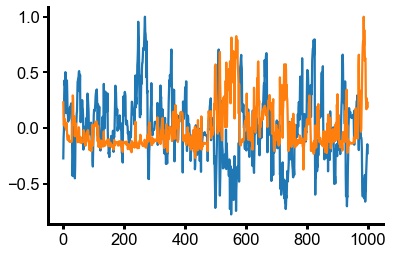

In [14]:
modeln = 0
t=0
dt=1000
mv_data = model_move[t:t+dt,modeln]
mv_data = mv_data - np.mean(mv_data)
mv_data = mv_data/np.max(mv_data)
sft_data = shift_out.cpu().detach().numpy()[t:t+dt,modeln]
sft_data = sft_data - np.mean(sft_data)
sft_data = sft_data/np.max(sft_data)
plt.plot(mv_data)
plt.plot(sft_data)

In [24]:
np.save(file=(save_dir / 'Shifted_worldcam_dt{:03d}.npy'.format(int(.025*1000))), arr=model_vid_sm_shift)

In [14]:
l=8
model_vid_sm_shift = model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] 

tensor([ 0.6099,  6.9809, -3.1397], device='cuda:0', grad_fn=<SelectBackward>)


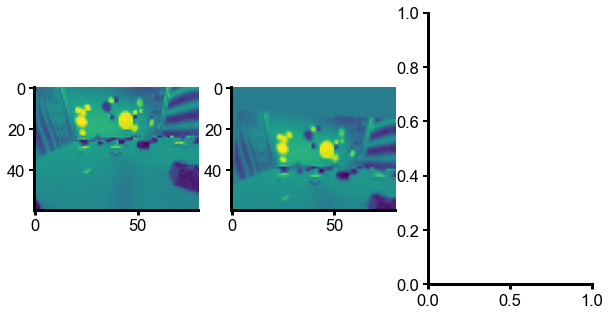

In [17]:
t = 2000
fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(model_vid_sm[t])

ax[1].imshow(model_vid_sm_shift[t])
# ax[2].imshow(model_vid_sm_shift_0[t])

print(shift_out[t])

In [20]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Uncorrected, Frame={}'.format(t))
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Corrected, Frame={}'.format(t))
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [21]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(10000)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = file_dict['name'] + '_WorldCamCorrection_dt{:03d}.mp4'.format(int(.05*1000))



vid_name = fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


  0%|          | 0/1000 [00:00<?, ?it/s]

(pid=424541) [2021-11-21 12:07:31,787 C 424541 424582] core_worker.cc:210:  Check failed: core_worker_process The core worker process is not initialized yet or already shutdown.
(pid=424541) *** StackTrace Information ***
(pid=424541)     ray::SpdLogMessage::Flush()
(pid=424541)     ray::RayLog::~RayLog()
(pid=424541)     ray::core::CoreWorkerProcess::EnsureInitialized()
(pid=424541)     ray::core::CoreWorkerProcess::GetCoreWorker()
(pid=424541)     __pyx_pw_3ray_7_raylet_10CoreWorker_23get_worker_id()
(pid=424541)     method_vectorcall_NOARGS
(pid=424541) 


  0%|          | 0/1000 [00:00<?, ?it/s]

Making Animation 070921_J553RT_control_Rig2_fm1_WorldCamCorrection_dt050.mp4: 14.40961217880249


7400

In [ ]:

GLM_VisMov_Shift = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis_NoL1', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 5000, Kfold))
locals().update(GLM_VisMov_Shift)


In [72]:
GLM_VisMov_Shift.keys()

dict_keys(['bias', 'loss_regcv', 'pred_test', 'pred_train', 'r2_test', 'sta_all', 'test_nsp', 'tloss_trace_all', 'vloss_trace_all'])

In [81]:
from scipy.stats import mode

In [83]:
mode(np.nanargmin(loss_regcv,axis=1)[0])

ModeResult(mode=array([12]), count=array([11]))

In [ ]:

celln = 49 # np.argmax(r2_test)
bin_length = 40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
bin_length=40
alph = 0#malph[celln]
lam = 0# mlam[celln]
for n, celln in enumerate(tqdm([12,13,20,25,49,51])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=5, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, :])])
    # axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :5//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (5//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    if MovModel != 0:
        crange = np.max(np.abs(sta_all[celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_test[:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*params['model_dt'],pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace_all[celln])
    f2_ax7.plot(vloss_trace_all[celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    
    if MovModel == 1:
        w_move = np.zeros((model_nsp.shape[-1],len(titles)))
    elif MovModel == 3:
        Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],params['nt_glm_lag'],len(titles))+nks)
        w_move = w_move[:,-len(titles):]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()


In [ ]:
model_vid_sm_shift2 = {}
for l in range(11,21):
    model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(model_type,'UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 5000,a,l,Kfold)
    checkpoint = torch.load(save_model2/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])

    ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')
    shift_mat = np.zeros((3,) + ang_sweepx.shape)
    for i in range(ang_sweepx.shape[0]):
        for j in range(ang_sweepy.shape[1]):
            ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T).to(device)
            shift_vec = l1.shifter_nn(ang_sweep).detach().cpu().numpy()
            shift_mat[0,i,j] = shift_vec[:,0]
            shift_mat[1,i,j] = shift_vec[:,1]
            shift_mat[2,i,j] = shift_vec[:,2]

        
    fig, ax = plt.subplots(2,2,figsize=(10,8))
    ax = ax.flatten()
    crange = np.max(np.abs(shift_mat[:2]))
    im1=ax[0].imshow(shift_mat[0,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[0].set_xticks(np.arange(0,90,20))
    ax[0].set_xticklabels(np.arange(-40,50,20))
    ax[0].set_yticks(np.arange(0,90,20))
    ax[0].set_yticklabels(np.arange(-40,50,20))
    ax[0].set_xlabel('Theta')
    ax[0].set_ylabel('Phi')
    ax[0].set_title('Horizontal Shift')


    im2=ax[1].imshow(shift_mat[1,:,:,40].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar2 = add_colorbar(im2)
    ax[1].set_xticks(np.arange(0,90,20))
    ax[1].set_xticklabels(np.arange(-40,50,20))
    ax[1].set_yticks(np.arange(0,90,20))
    ax[1].set_yticklabels(np.arange(-40,50,20))
    ax[1].set_xlabel('Theta')
    ax[1].set_ylabel('Phi')
    ax[1].set_title('Vertical Shift')

    crange = np.max(np.abs(shift_mat[2]))
    im3=ax[2].imshow(shift_mat[2,:,40,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar3 = add_colorbar(im3)
    ax[2].set_xticks(np.arange(0,90,20))
    ax[2].set_xticklabels(np.arange(-40,50,20))
    ax[2].set_yticks(np.arange(0,90,20))
    ax[2].set_yticklabels(np.arange(-40,50,20))
    ax[2].set_xlabel('Theta')
    ax[2].set_ylabel('Pitch')
    ax[2].set_title('Rotational: Phi=0')

    im4=ax[3].imshow(shift_mat[2,40,:,:].T,vmin=-crange, vmax=crange, origin='lower', cmap='RdBu_r')
    cbar4 = add_colorbar(im4)
    ax[3].set_xticks(np.arange(0,90,20))
    ax[3].set_xticklabels(np.arange(-40,50,20))
    ax[3].set_yticks(np.arange(0,90,20))
    ax[3].set_yticklabels(np.arange(-40,50,20))
    ax[3].set_xlabel('Phi')
    ax[3].set_ylabel('Pitch')
    ax[3].set_title('Rotational: Theta=0')
    plt.tight_layout()
    # fig.savefig(fig_dir/'ThetaPhiPitch_Shifter_lam{}.pdf'.format(l), facecolor='white', transparent=True, bbox_inches='tight')

    # shift_out = l1.shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)).to(device))
    # shift = Affine(angle=shift_out[:,-1],translation=shift_out[:,:2])
    # model_vid_sm_shift = shift(torch.from_numpy(model_vid_sm[:,np.newaxis].astype(np.float32)).to(device)).detach().cpu().numpy().squeeze()

    # model_vid_sm_shift2['model_vid_sm_shift{}'.format(l)] = model_vid_sm_shift
# ioh5.save(save_dir/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), MovModel),model_vid_sm_shift2)

# Raster Plots

In [ ]:

ephys_file = save_dir/'RawEphysData.h5'
ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']
Tmax = 5
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>0) &(spks < Tmax)])


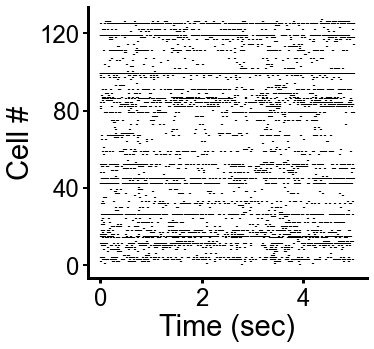

In [46]:
fontsize=24
fig,axs = plt.subplots(figsize=(5,5))
ax = axs
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('Time (sec)',fontsize=fontsize+5)
ax.set_ylabel('Cell #',fontsize=fontsize+5)
ax.set_yticks(np.arange(0,140,40))
ax.set_yticklabels(np.arange(0, 140, 40),fontsize=fontsize)
ax.set_xticks(np.arange(0, 6, 2))
ax.set_xticklabels(np.arange(0, 6, 2), fontsize=fontsize)

plt.show()
fig.savefig(fig_dir/'SpikeRaster.pdf', facecolor='white', transparent=True, bbox_inches='tight')


# WorldCam/EyeCam/IMU Example

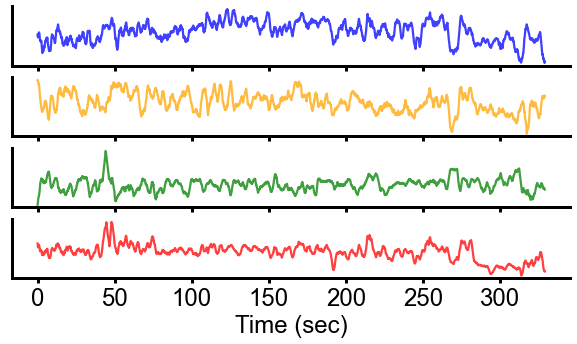

In [24]:
celln = 126
bin_length=40
titles = np.array(['theta', 'phi', 'rho', 'omega'])
clrs = ['blue', 'orange', 'green', 'red']
fontsize=24
fig, axs = plt.subplots(4,1,figsize=(10,5),sharex=True)
for modeln,ax in enumerate(axs):
    sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move = np.zeros((len(titles), sp_smooth.shape[0]))
    smooth1 = ((np.convolve(move_test[:,modeln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move[modeln] = (smooth1 - np.nanmean(smooth1))/np.max(smooth1)
    ax.plot(np.arange(smooth_move[modeln].shape[0])*model_dt, smooth_move[modeln],c=clrs[modeln], label=r'$\{}$'.format(titles[modeln]),alpha=.75)
    ax.set_yticks([])
axs[-1].tick_params(axis='x', labelsize=fontsize)
axs[-1].set_xlabel('Time (sec)',fontsize=fontsize)
fig.savefig(fig_dir/'IMU_Example.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [16]:
WC_raw = np.load('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/uncorrected_worldcam_dt025.npy')

In [11]:
WC_raw.shape,model_vid_sm_shift.shape

((146765, 120, 160), (22326, 30, 40))

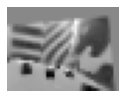

In [19]:
fig,axs = plt.subplots(1,figsize=(2,2))
# axs.imshow(WC_raw[1000], cmap='gray')
axs.imshow(model_vid_sm_shift[2000], cmap='gray')
axs.axis('off')
fig.savefig(fig_dir/'WC_DSIm.pdf', facecolor='white', transparent=True, bbox_inches='tight')

# axs[1].imshow(model_vid_sm_shift[1000])

# Position Only

In [10]:
params['nt_glm_lag']

5

In [11]:
'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs, Kfold)

'GLM_Pytorch_Mot_VisMov_dt050_T05_MovModel0_NB12000_Kfold00.h5'

Done Loading Unaligned data
Done Loading Unaligned data
Done Loading Unaligned data


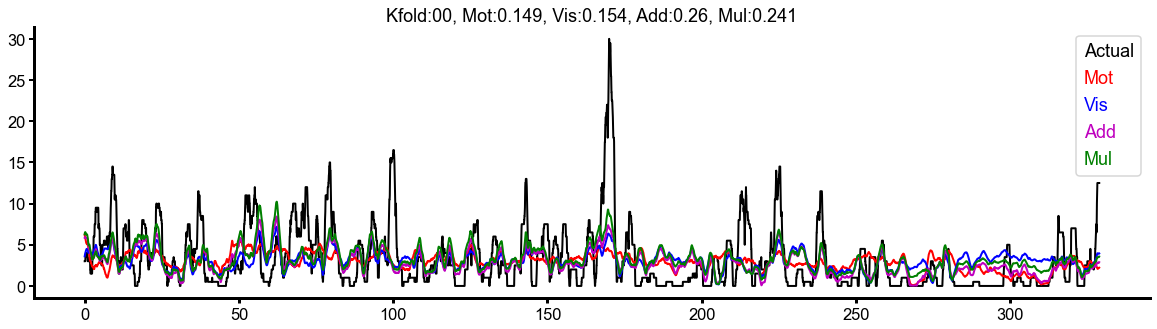

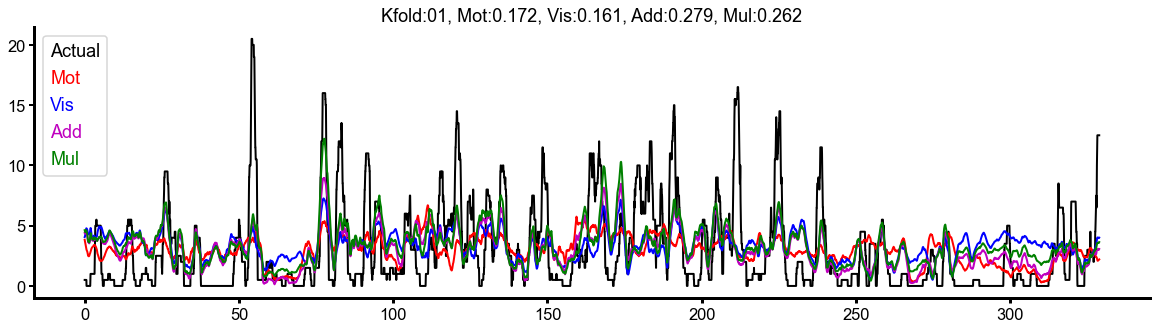

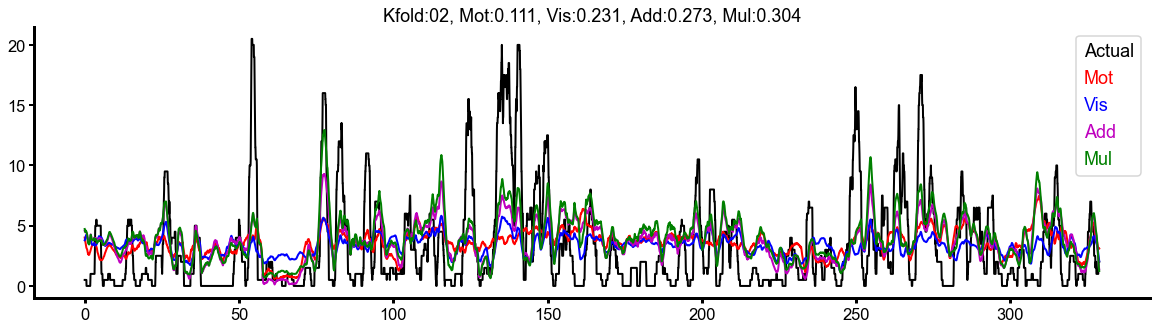

In [17]:
celln = 101
bin_length=40
Nepochs = 5000
fontsize = 24
for Kfold in range(3):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs, Kfold))
    GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
    GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))
    GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))

    fig,ax = plt.subplots(figsize=(20,5))
    sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Mot = ((np.convolve(GLM_VisMov_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2,label='Actual')
    ax.plot(np.arange(len(pred_smooth_Mot))*params['model_dt'],pred_smooth_Mot,'r', lw=2,label='Mot')
    ax.plot(np.arange(len(pred_smooth_Vis))*params['model_dt'],pred_smooth_Vis,'b', lw=2,label='Vis')
    ax.plot(np.arange(len(pred_smooth_Add))*params['model_dt'],pred_smooth_Add,'m', lw=2,label='Add')
    ax.plot(np.arange(len(pred_smooth_Mul))*params['model_dt'],pred_smooth_Mul,'g', lw=2,label='Mul')
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
    ax.set_xlabel('Time (s)',fontsize=fontsize)
    ax.set_ylabel('Spike Rate',fontsize=fontsize)
    r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
    r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
    r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
    r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2
    ax.set_title('Kfold:{:02d}, Mot:{:.03}, Vis:{:.03}, Add:{:.03}, Mul:{:.03}'.format(Kfold, r2_Mot,r2_Vis,r2_Add,r2_Mul))
    fig.savefig(fig_dir/'ExamplePredFR_celln{}_Kfold{:02d}.png'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')


In [7]:
Kfold = 2
Nepochs=5000
bin_length = 40
move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_VisMov_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 5000, Kfold))
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))


Done Loading Unaligned data


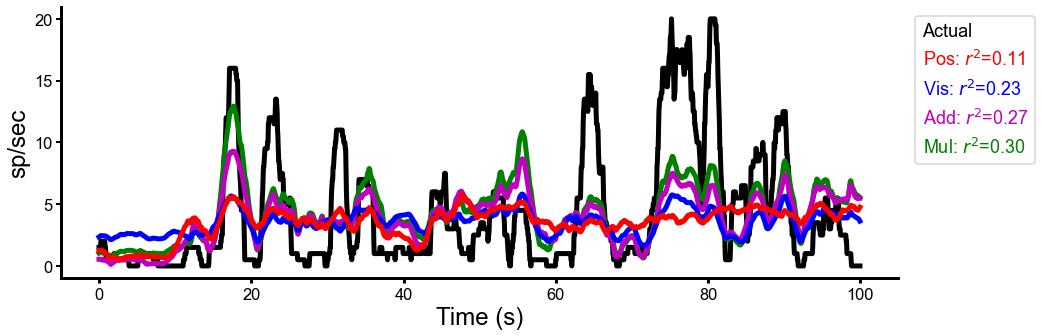

In [13]:

celln = 101
t = 1200
dt = 2000
fontsize=24
fig,ax = plt.subplots(figsize=(15,5))
sp_smooth = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

pred_smooth_Mot = ((np.convolve(GLM_VisMov_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Add = ((np.convolve(GLM_VisMov_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Mul = ((np.convolve(GLM_VisMov_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2

ax.plot(np.arange(len(sp_smooth[t:t+dt]))*params['model_dt'],sp_smooth[t:t+dt], 'k', lw=5,label='Actual', zorder=0)
ax.plot(np.arange(len(pred_smooth_Mot[t:t+dt]))*params['model_dt'],pred_smooth_Mot[t:t+dt],'r', lw=5,label='Pos: $r^2$={:.02f}'.format(r2_Mot), zorder=4)
ax.plot(np.arange(len(pred_smooth_Vis[t:t+dt]))*params['model_dt'],pred_smooth_Vis[t:t+dt],'b', lw=5,label='Vis: $r^2$={:.02f}'.format(r2_Vis), zorder=3)
ax.plot(np.arange(len(pred_smooth_Add[t:t+dt]))*params['model_dt'],pred_smooth_Add[t:t+dt],'m', lw=5,label='Add: $r^2$={:.02f}'.format(r2_Add), zorder=2)
ax.plot(np.arange(len(pred_smooth_Mul[t:t+dt]))*params['model_dt'],pred_smooth_Mul[t:t+dt],'g', lw=5,label='Mul: $r^2$={:.02f}'.format(r2_Mul), zorder=1)
ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True, bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

fig.savefig(fig_dir/'Mul_ExamplePredFR_celln{}_Kfold{:02d}.pdf'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')

In [35]:
params

{'Nepochs': 12000,
 'model_dt': 0.05,
 'do_shuffle': False,
 'do_norm': False,
 'do_worldcam_correction': False,
 'lag_list': array([-2, -1,  0,  1,  2]),
 'free_move': True,
 'save_dir': PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1'),
 'data_dir': PosixPath('/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1'),
 'fig_dir': PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/070921/J553RT/fm1'),
 'save_model': PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/models/1'),
 'shiftn': 7,
 'train_shifter': False,
 'MovModel': 1,
 'load_Vis': False,
 'LinMix': False,
 'LinNonLinMix': False,
 'NKfold': 3,
 'nt_glm_lag': 5,
 'WC_type': 'UC',
 'move_features': None,
 'alphas': array([0.009]),
 'lambdas': array([1.00000000e-03, 1.00000000e-03, 2.13278643e-03, 4.54877795e-03,
        9.70157187e-03, 2.06913808e-02, 4.41302962e-02, 9.41204967e-02,
        2.00738918e-01, 4.28133240e-01, 9.131167

# Hidden Layer Vis Training

In [3]:
args = arg_parser(jupyter=True)

MovModel = 1
LinMix = False
args['LinNonLinMix']=False
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# 128: 070921/J553RT
# '110421/J569LT'# #'062921/G6HCK1ALTRN' '102621/J558NC'  # '110421/J569LT' #
# date_ani = '110421/J569LT'# args['date_ani']
# date_ani = '102621/J558NC' 
date_ani = '070921/J553RT' 
date_ani2 = '_'.join(date_ani.split('/'))
data_dir = Path(args['data_dir']).expanduser() / date_ani / stim_type 
save_dir = (Path(args['save_dir']).expanduser() / date_ani/ stim_type)
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_fm = save_dir.parent / 'fm1'
save_dir_hf = save_dir.parent / 'hf1_wn'
fig_dir = (Path(args['fig_dir']).expanduser()/'Encoding'/date_ani/stim_type)
fig_dir.mkdir(parents=True, exist_ok=True)
save_model = (save_dir/ 'models' / '{}'.format(MovModel))
save_model.mkdir(parents=True, exist_ok=True)

file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'mapping_json': Path('~/Research/Github/FreelyMovingEphys/probes/channel_maps.json').expanduser(),
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_' + stim_type,  # 070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }
params = {
    'Nepochs': args['Nepochs'],
    'model_dt': .05,
    'do_shuffle': False,
    'do_norm': False,
    'do_worldcam_correction': False,
    'lag_list': np.array([-2, -1, 0, 1, 2]),
    'free_move': free_move,
    'save_dir': save_dir,
    'save_dir_fm': save_dir_fm,
    'save_dir_hf': save_dir_hf,
    'data_dir': data_dir,
    'fig_dir': fig_dir,
    'save_model': save_model,
    'shiftn': 7, 
    'train_shifter': False,
    'MovModel': MovModel,
    'load_Vis' : True if MovModel==2 else False,
    'LinMix': False if args['LinNonLinMix']==True else args['LinMix'],
    'LinNonLinMix': args['LinNonLinMix'],
    'NKfold': args['NKfold'],
    'NoL1': args['NoL1'],
}
params['nt_glm_lag']=len(params['lag_list'])
Nepochs = params['Nepochs']
if params['do_worldcam_correction']:
    params['WC_type'] = 'C'
else:
    params['WC_type'] = 'UC'

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, hidden_size, output_size, model_type, meanbias = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


Done Loading Unaligned data
Model: 1, move_features: None


In [92]:
hidden_size = 2
Cell_NN = {'{}'.format(celln):nn.Sequential(nn.Linear(input_size, hidden_size),nn.Softplus(),nn.Linear(hidden_size, 1)) for celln in range(params['Ncells'])}


visNN = nn.ModuleDict(Cell_NN).to(device)


output = []
for celln in range(params['Ncells']):
    output.append(visNN['{}'.format(celln)](xtr))
output = torch.stack(output).squeeze().T
output = torch.nn.ReLU()(output)


loss = torch.mean((output-ytr)**2,axis=0)
optimizer.zero_grad()
loss_like = torch.zeros_like(loss)
loss_like[1] = 1
loss.backward(loss_like)
optimizer.step()


In [102]:
# l1_reg = nn.L1Loss(reduction='none')
# l1_reg(output,ytr)
torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '0.weight' in name])
torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '2.weight' in name])

torch.Size([128])

In [97]:
l1_reg(output,ytr).shape

torch.Size([15628, 128])

In [ ]:
l1_reg = torch.linalg.vector_norm(visNN.Layer0.weight,ord=1) + torch.linalg.vector_norm(visNN.Layer1.weight, dim=1, ord=1)

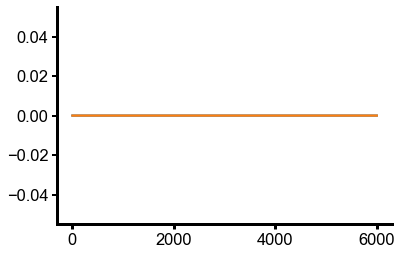

In [94]:
plt.plot(visNN['0'][0].weight.grad.clone().detach().cpu().T)

In [60]:
optimizer = optim.Adam(params=[{'params': [NN_params for name, NN_params in visNN.named_parameters() if '0.weight' in name],'lr':params['lr_w'][0],'weight_decay':params['lambdas'][l]},
                                {'params': [NN_params for name, NN_params in visNN.named_parameters() if '2.weight' in name],'lr':params['lr_w'][1]},
                                {'params': [param for name,param in visNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])

In [136]:

class VisNetwork(nn.Module):
    def __init__(self, 
                    in_features, 
                    hidden_features,
                    N_cells, 
                    shift_in=3, 
                    shift_hidden=20,
                    shift_out=3,
                    hidden_move=15,
                    reg_alph=None, 
                    reg_alphm=None, 
                    move_features=None, 
                    LinMix=False,
                    train_shifter=False,
                    device='cuda'):
        super(VisNetwork, self).__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.N_cells = N_cells
        self.move_features = move_features
        self.LinMix = LinMix

        Cell_NN = {'{}'.format(celln):nn.Sequential(nn.Linear(input_size, hidden_size),nn.Softplus(),nn.Linear(hidden_size, 1)) for celln in range(N_cells)}
        self.visNN = nn.ModuleDict(Cell_NN)
        self.activations = nn.ModuleDict({'SoftPlus':nn.Softplus(),
                                          'ReLU': nn.ReLU(),
        })
        # Initialize Regularization parameters
        self.reg_alph = reg_alph
        if self.reg_alph != None:
            self.alpha = reg_alph*torch.ones(1).to(device)

        # Initialize Movement parameters
        self.reg_alphm = reg_alphm
        if self.move_features != None:
            if reg_alphm != None:
                self.alpha_m = reg_alphm*torch.ones(1).to(device)
            self.posNN = nn.ModuleDict({'Layer0': nn.Linear(move_features, 1)})

        # option to train shifter network
        self.train_shifter = train_shifter
        self.shift_in = shift_in
        self.shift_hidden = shift_hidden
        self.shift_out = shift_out
        if train_shifter:
            self.shifter_nn = nn.Sequential(
                nn.Linear(self.shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out)
            )
  
    def forward(self, inputs, move_input=None, eye_input=None):
        if self.train_shifter: 
            batchsize, timesize, x, y = inputs.shape
            dxy = self.shifter_nn(eye_input)
            shift = Affine(angle=dxy[:,-1],translation=dxy[:,:2])
            inputs = shift(inputs)
            inputs = inputs.reshape(batchsize,-1).contiguous()
        # fowrad pass of GLM 
        x, y = inputs.shape    
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        
        output = []
        for celln in range(self.N_cells):
            output.append(self.visNN['{}'.format(celln)](inputs))
        output = torch.stack(output).squeeze().T

        # Add Vs. Multiplicative
        if move_input != None:
            if self.LinMix==True:
                output = output + self.posNN['Layer0'](move_input)
            else:
                move_out = self.posNN['Layer0'](move_input)
                # move_out = self.activations['SoftPlus'](move_out)
                move_out = torch.exp(move_out)
                output = output*move_out
        ret = self.activations['ReLU'](output)
        return ret
    
    def loss(self,Yhat, Y): 
        if self.LinMix:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
        else:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
            # loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0)  # Log-likelihood
        if self.move_features != None:
            if self.reg_alph != None:
                l1_reg0 = self.alpha0*(torch.linalg.norm(self.visNN['Layer0'].weight,axis=1,ord=1))
                l1_reg1 = self.alpha1*(torch.linalg.norm(self.visNN['Layer1'].weight,axis=1,ord=1))
            else: 
                l1_reg0 = 0
                l1_reg1 = 0
            if self.reg_alphm != None:
                l1_regm = self.alpha_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1))
            else: 
                l1_regm = 0
            loss_vec = loss_vec + l1_reg0 + l1_reg1 + l1_regm
        else:
            if self.reg_alph != None:
                l1_reg0 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '0.weight' in name])
                l1_reg2 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '2.weight' in name])
                loss_vec = loss_vec + self.alpha*(l1_reg0 +l1_reg2)
        
        return loss_vec

In [106]:
output = l1(xtr)

In [41]:
input_size

6000

In [108]:
hidden_size=2
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)

In [38]:
lr = 1e-1
for n in range(1000):
    lr = lr*.995
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.99)
lr

0.0006653968578831972

In [4]:
a = 0
params['Nepochs'] = 1000
params['alphas'] = [None]
params['lr_w'] = [1e-1, 5e-2]
params['lr_b'] = [1e-1, 5e-2]
params['lr_m'] = [1e-6, 1e-3]
params['lambdas'] = np.array([np.logspace(-3, 5, 20)[8]]) #np.hstack((np.logspace(-3, 5, 20)[0], np.logspace(-3, 5, 20)))
params['nlam'] = len(params['lambdas'])
hidden_size = 2
loss_regcv = np.zeros((params['nalph'], params['nlam'], output_size))
pred_cv = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
out_cv = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
tloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size,params['Nepochs']), dtype=np.float32)
vloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size,params['Nepochs']), dtype=np.float32)

# pbar = tqdm(params['lambdas_m'])
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)
# torch.nn.init.zeros_(l1.visNN.Layer0.weight)
state_dict = l1.state_dict()
l1_params_cv = {}
for name, NN_param in l1.named_parameters():
    l1_params_cv[name] = []
# visNN_traces = l1_params_cv.copy()
pbar = tqdm(params['lambdas'])
for l, reg_lam in enumerate(pbar):
    l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                    move_features=params['move_features'], train_shifter=False, 
                    LinMix=params['LinMix'], device=device,).to(device)
    # if (l == 0) & (MovModel==1):
    #     torch.nn.init.zeros_(l1.visNN.Layer0.weight)
    # state_dict['visNN.Layer1.bias'] = meanbias
    l1.load_state_dict(state_dict)
    if MovModel == 1:
        optimizer = optim.Adam(params=[{'params': [p],'lr':params['lr_w'][0],'weight_decay':params['lambdas'][l]} for name, p in l1.visNN.named_parameters() if '0.weight' in name] + \
                                        [{'params': [p],'lr':params['lr_w'][1]}  for name, p in l1.visNN.named_parameters() if '2.weight' in name] + \
                                        [{'params': [p],'lr':params['lr_b'][0]} for name, p in l1.visNN.named_parameters() if 'bias' in name])
    elif MovModel == 2:
         
        optimizer = optim.Adam(params=[{'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
                                        {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])
    
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(params['Nepochs']/10))
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995)
    vloss_trace = np.zeros((ytr.shape[-1], params['Nepochs']), dtype=np.float32)
    tloss_trace = np.zeros((ytr.shape[-1], params['Nepochs']), dtype=np.float32)

    # if pbar is None:
    #     pbar = pbar2 = tqdm(np.arange(Nepochs))
    # else:
    pbar2 = tqdm(np.arange(params['Nepochs']))
    for batchn in pbar2:
        out = l1(xtr, xtrm, shift_in_tr)
        loss = l1.loss(out, ytr)
        pred = l1(xte, xtem, shift_in_te)
        val_loss = l1.loss(pred, yte)
        vloss_trace[:,batchn] = val_loss.clone().cpu().detach().numpy()
        tloss_trace[:,batchn] = loss.clone().cpu().detach().numpy()
        pbar2.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
        pbar2.refresh()
        optimizer.zero_grad()
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        scheduler.step()
        # for name, NN_param in l1.named_parameters():
        #     visNN_traces[name].append(NN_param.clone().detach().cpu().numpy())

    if (l == 0) & (MovModel==1):
        state_dict = l1.state_dict()
    tloss_trace_all[a, l] = tloss_trace
    vloss_trace_all[a, l] = vloss_trace
    for name, NN_p in l1.named_parameters():
        l1_params_cv[name].append(NN_p.clone().detach().cpu().numpy())
    pred = l1(xte, xtem)
    loss_regcv[a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    pred_cv[a, l] = pred.detach().cpu().numpy().squeeze().T
    out = l1(xtr, xtrm)
    out_cv[a, l] = out.detach().cpu().numpy().squeeze().T



AttributeError: 'VisNetwork' object has no attribute 'input_features'

In [258]:
l1_params_cv = {}
for name, NN_param in l1.named_parameters():
    l1_params_cv[name] = []
for name, NN_p in l1.named_parameters():
    l1_params_cv[name].append(NN_p.clone().detach().cpu().numpy())

In [341]:
l1.visNN['0'][2].bias

Parameter containing:
tensor([-0.6765], device='cuda:0', requires_grad=True)

In [344]:
meanbias[celln]

tensor(0.0603)

<All keys matched successfully>

In [ ]:

for name in l1_params_cv.keys():
    # visNN_traces[name] = np.stack(visNN_traces[name])
    l1_params_cv[name] = np.stack(l1_params_cv[name])


# if (MovModel == 1):
#     loss_regcv[:, 0, :] = np.nan
malph, mlam, cellnum = np.where(loss_regcv == np.nanmin(loss_regcv, axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

visNN_best = {}
posNN_best = {}
for name in l1_params_cv.keys():
    visNN_best[name] = l1_params_cv[name][mlam]
        # posNN_best[name] = l1_params_cv[name][mlam]
        
pred_test = pred_cv[malph, mlam, cellnum]
pred_train = out_cv[malph, mlam, cellnum]
tloss_trace_all2 = tloss_trace_all[malph, mlam, cellnum]
vloss_trace_all2 = vloss_trace_all[malph, mlam, cellnum]

output_size = len(cellnum)
bin_length = 40
r2_test = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(data['test_nsp'][:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_test[celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    r2_test[celln] = (np.corrcoef(sp_smooth, pred_smooth)[0, 1])**2


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


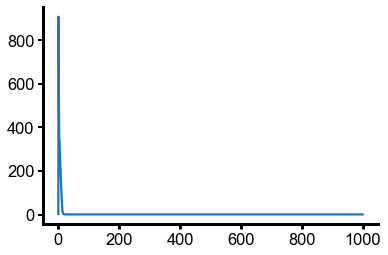

In [371]:
plt.plot(vloss_trace_all2[51].T)
plt.show()

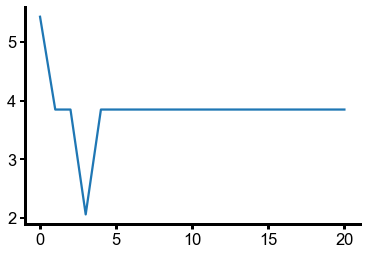

In [367]:
plt.plot(loss_regcv[0,:,126])


In [237]:
visNN_traces['visNN.0.0.bias'].shape

(1201, 2)

In [301]:
visNN_traces['visNN.{}.0.weight'.format(celln)].shape

(201, 2, 6000)

tensor(0.2656)

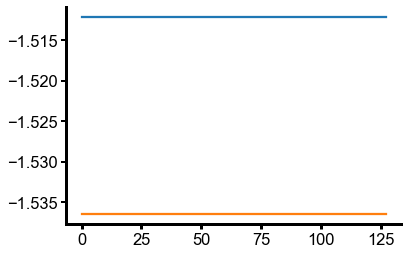

In [372]:
celln = 51
plt.plot(visNN_best['visNN.{}.0.bias'.format(celln)])
# plt.plot(visNN_traces['visNN.Layer1.weight'][:,celln])
meanbias[celln]

In [107]:
pred_test.shape

(0, 6698)

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5, 1.0, '$r^2$: nan')

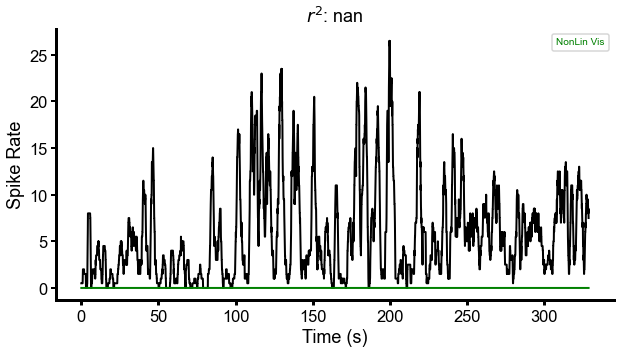

In [36]:
celln = 51
bin_length=40
fig, ax = plt.subplots(1,1,figsize=(10,5))
sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
pred_smooth_nonlin_Vis = ((np.convolve(GLM_VisMov_NonLinVis['pred_test'][celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
# pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_nonlin_Vis))*params['model_dt'],pred_smooth_nonlin_Vis,'g', lw=2,label='NonLin Vis')
# ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'r', lw=2,label='Lin Vis')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike Rate')
ax.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
r2_NonLinVis = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2
# r2_LinVis = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
ax.set_title('$r^2$: {:.03f}'.format(r2_NonLinVis))

In [ ]:
model_type = 'Pytorch_NonLinVis'


In [ ]:

if MovModel == 0:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_test,
                'pred_train': pred_train,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'visNN': visNN_best,
                'posNN': posNN_best,
                }
elif MovModel == 1:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_train': pred_train,
                'pred_test': pred_test,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'visNN': visNN_best,
                }
else:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_test,
                'pred_train': pred_train,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'visNN': visNN_best,
                'posNN': posNN_best,
                }
if params['do_shuffle']:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_shuffled.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, params['Nepochs'],Kfold)
else:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, params['Nepochs'], Kfold)
ioh5.save(save_datafile, GLM_Data)

In [16]:
params['Nepochs']

12000

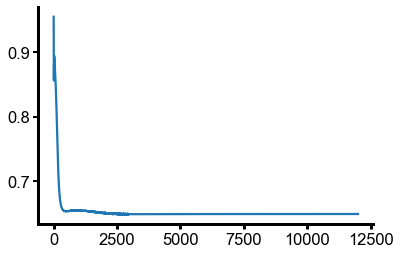

In [140]:
celln = 117
plt.plot(vloss_trace_all2[celln])

In [6]:
Layer1_W = torch.zeros(params['Ncells']*2,params['nk'])
Layer2_W = torch.zeros(params['Ncells']*2,output_size)

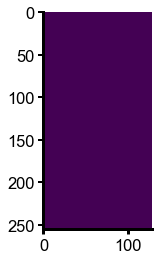

In [11]:
Layer2_W[:2,0] = 1
plt.imshow(Layer2_W)

In [20]:
sta_in = []
for celln in range(params['Ncells']):
    sta_in.append(GLM_VisMov_NonLinVis['visNN']['visNN.{}.0.weight'.format(celln)][-1].reshape((2,params['nt_glm_lag'])+params['nks']))
sta_in = np.stack(sta_in)

In [233]:
celln = 117
l1_params_cv['visNN.{}.2.weight'.format(celln)][-1]

array([[0.47829238, 0.36350375]], dtype=float32)

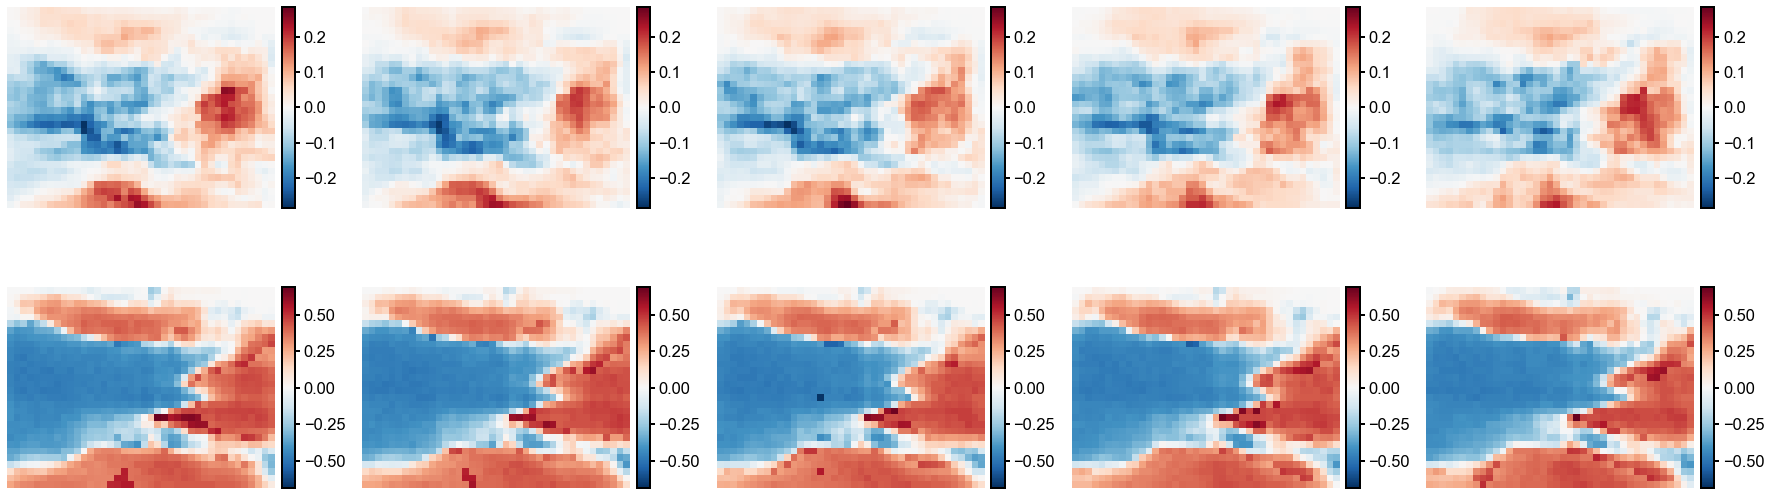

In [23]:
celln = 25
fig, axs = plt.subplots(hidden_size,params['nt_glm_lag'], figsize=(params['nt_glm_lag']*5,hidden_size*5))
for n in range(hidden_size):
    crange = np.max(np.abs(sta_in[celln,n]))
    for m in range(params['nt_glm_lag']):
        ax=axs[n,m]
        im = ax.imshow(sta_in[celln,n,m],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')
    plt.tight_layout()


In [139]:
visNN_best['visNN.Layer1.weight'][celln]

array([0.14337343, 0.55006164], dtype=float32)

In [3]:
hidden_size = output_size
l = 9
params['lr_w'] = [1e-6, 1e-4]
params['lr_b'] = [1e-6, 1e-2]
l1 = VisNetwork(input_size, hidden_size, output_size, 
                # reg_alph=.01,
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)
# optimizer = optim.Adam(params=[{'params': [param for name,param in l1.visNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
#                                 {'params': [param for name,param in l1.visNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(params['Nepochs']/4))

In [21]:
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
sta_init = GLM_VisMov_Vis['sta_all'].reshape(ncells,-1)
state_dict = l1.state_dict()
state_dict['visNN.Layer0.weight'] = torch.from_numpy(sta_init.astype(np.float32))
l1.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
Nepochs = 10000
vloss_trace = np.zeros((Nepochs, ytr.shape[-1]), dtype=np.float32)
tloss_trace = np.zeros((Nepochs, ytr.shape[-1]), dtype=np.float32)
pbar = tqdm(np.arange(Nepochs))
for batchn in pbar:
    out = l1(xtr, xtrm, shift_in_tr)
    loss = l1.loss(out, ytr)
    pred = l1(xte, xtem, shift_in_te)
    val_loss = l1.loss(pred, yte)
    vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
    tloss_trace[batchn] = loss.clone(). cpu().detach().numpy()
    pbar.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
    pbar.refresh()
    optimizer.zero_grad()
    loss.backward(torch.ones_like(loss))
    optimizer.step()
pred_test = l1(xte, xtem, shift_in_te).detach().cpu().numpy()


  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
ncells = data['model_nsp'].shape[-1]
l0_w = l1.visNN['Layer0'].weight.clone().detach().cpu().numpy().reshape((ncells,params['nt_glm_lag'],)+nks)
l1_w = l1.visNN['Layer1'].weight.clone().detach().cpu().numpy()

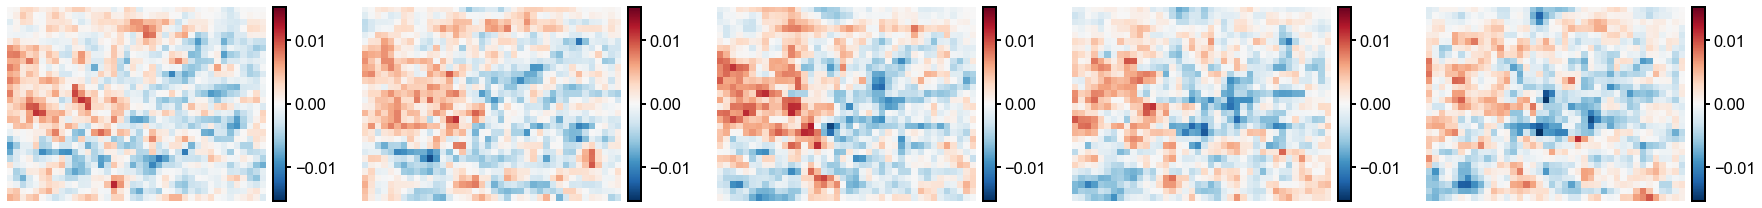

In [26]:
celln = 121
fig, axs = plt.subplots(1,params['nt_glm_lag'], figsize=(params['nt_glm_lag']*5,5))
axs = axs.flatten()
crange = np.max(np.abs(sta_all[celln]))
for m,ax in enumerate(axs):
    im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.axis('off')
plt.tight_layout()


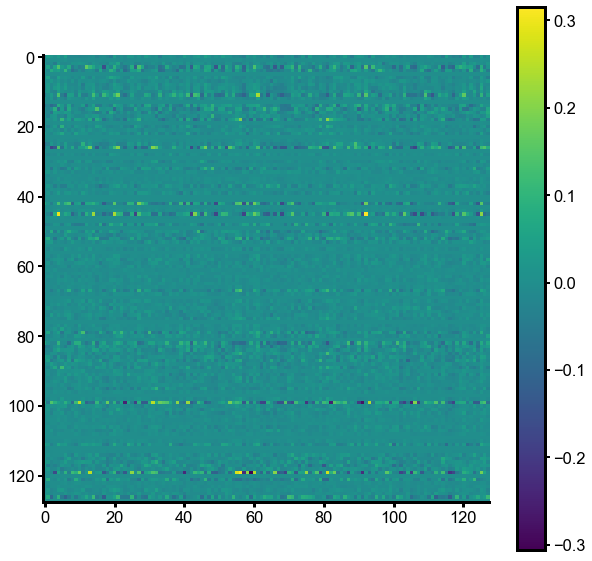

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(l1_w)
plt.colorbar()

In [ ]:
r2_Vis_all = np.zeros((params['Ncells']))
r2_nonlin_Vis_all = np.zeros((params['Ncells']))
for celln,_ in enumerate(tqdm(np.arange(params['Ncells']))):
    sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_nonlin_Vis = ((np.convolve(pred_test[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_Vis_all[celln] = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
    r2_nonlin_Vis_all[celln] = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2


In [202]:
GLM_VisMov_NonLinVis['visNN'].keys()
GLM_Pytorch_NonLinVis_VisMov_dt050_T05_MovModel1_NB1000_Kfold00
GLM_Pytorch_NonLinVis_VisMov_dt050_T05_MovModel1_NB10000_Kfold00

dict_keys(['visNN.Layer0.bias', 'visNN.Layer0.weight', 'visNN.Layer1.bias', 'visNN.Layer1.weight'])

In [13]:
save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 10000, Kfold)

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_NonLinVis_VisMov_dt050_T05_MovModel1_NB10000_Kfold00.h5')

In [17]:
Kfold = 0
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
GLM_VisMov_NonLinVis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 1000, Kfold))

In [18]:
GLM_VisMov_NonLinVis.keys()

dict_keys(['loss_regcv', 'pred_test', 'pred_train', 'r2_test', 'test_nsp', 'tloss_trace_all', 'visNN', 'vloss_trace_all'])

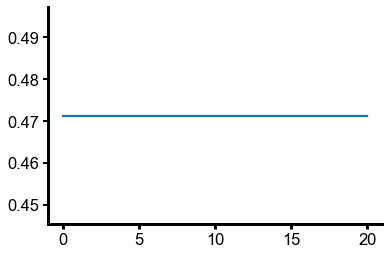

In [29]:
plt.plot(GLM_VisMov_NonLinVis['loss_regcv'][0,:,51])

In [24]:
sta_in = []
for celln in range(params['Ncells']):
    sta_in.append(GLM_VisMov_NonLinVis['visNN']['visNN.{}.0.weight'.format(celln)][-1].reshape((2,params['nt_glm_lag'])+params['nks']))
sta_in = np.stack(sta_in)

In [ ]:
save_pdf = False
bin_length=40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
spk_percentile2 = np.arange(.125,1.125,.25)
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

fontsize = 24
Kfold = 0
Nepochs = 5000
move_train,mov_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
locals().update(params)

pbar = tqdm([21,25,49,51,61,62,88,117,121,126])
# pbar = tqdm(np.arange(model_nsp.shape[-1]))
pdf_name = fig_dir/ 'VisMov_{}_dt{:03d}_Lags{:02d}_Kfold{:02d}_CellSummary.pdf'.format('Pytorch_VisMov_NonLinVis',int(params['model_dt']*1000),params['nt_glm_lag'],Kfold)
if save_pdf:
    pdf = PdfPages(pdf_name)
for n, celln in enumerate(pbar): 
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(params['nt_glm_lag'])])
    axs3a = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    f2_ax6 = fig2.add_subplot(spec2[1, :params['nt_glm_lag']//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (params['nt_glm_lag']//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    f2_ax8b = fig2.add_subplot(spec2[2,-1])
    if MovModel != 0:
        crange = np.max(np.abs(GLM_VisMov_NonLinVis['sta_all'][celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_VisMov_NonLinVis['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
    pred_smooth_nonlin_Vis = ((np.convolve(GLM_VisMov_NonLinVis['pred_test'][celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth_nonlin_Vis))*model_dt,pred_smooth_nonlin_Vis,'g', lw=2,label='NonLin Vis')
    f2_ax6.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'r', lw=2,label='Lin Vis')
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax6.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
    r2_NonLinVis = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2
    r2_LinVis = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
    
    f2_ax7.plot(GLM_VisMov_NonLinVis['vloss_trace_all'][celln], label='NonLin Vis Te')
    f2_ax7.plot(GLM_VisMov_Vis['vloss_trace_all'][celln], label='LinVis Te')
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    f2_ax7.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0, fancybox=True)

    # w_move_Add = GLM_VisMov_Add['w_move']
    # w_move_Mov = GLM_VisMov_Mul['w_move']
    # for modeln in range(len(titles)):
    #     f2_ax8.bar(modeln, w_move_Add[celln,modeln], color=clrs[modeln])
    #     f2_ax8.set_xticks(np.arange(0,len(titles)))
    #     f2_ax8.set_xticklabels(titles)
    #     f2_ax8.set_ylabel('GLM Weight')
    #     f2_ax8.set_title('Add Weights')
    #     f2_ax8b.bar(modeln, w_move_Mov[celln,modeln], color=clrs[modeln])
    #     f2_ax8b.set_xticks(np.arange(0,len(titles)))
    #     f2_ax8b.set_xticklabels(titles)
    #     f2_ax8b.set_ylabel('GLM Weight')
    #     f2_ax8b.set_title('Mul Weights')

    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs3a[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

        axs3a[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs3a[modeln].set_xlim(-30,30)
        axs3a[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs3a[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs3a[modeln].set_title(titles[modeln],fontsize=fontsize)


    plt.suptitle(' celln: {}\n LinVis $r^2$: {:.03f}, NonLinVis $r^2$:{:.03f}'.format(celln, r2_LinVis, r2_NonLinVis))
    plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()


In [37]:
pdf.close()


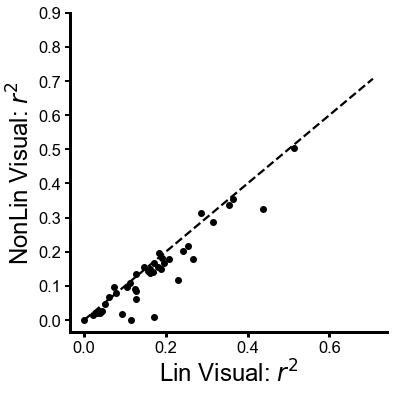

In [203]:
a = 0; l = 0
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40
fig, ax = plt.subplots(figsize=(6,6))
xvals = GLM_VisMov_Vis['r2_test'] #[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
yvals = r2_test # GLM_VisMov_NonLinVis['r2_test'] #[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
# yvals2 = r2_Add#[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, lim_max)
ax.scatter(xvals,yvals,30,c='k', label='Mul')
# ax.scatter(xvals,yvals2,30,c='m', label='Add')
# ax.scatter(xvals,yvals3,30,c='k', label='AddMul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Lin Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('NonLin Visual: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=1))
# leg = ax.legend()
# for handle, text in zip(leg.legendHandles, leg.get_texts()):
#     text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()
# fig.savefig(fig_dir/'NonLinVis_Vs_LinVis{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



6000 to 4 per unit to 128 units